# How The Number of Hours Worked Differs Based on a Person's Marital Status, Education and Workclass

Siddharth Nand    
Charul Maheshka    
Winston ONG    
Simon Liang    

<hr style="opacity: 0.3" />

# Introduction

We are interested in the factors that impact number of hours worked per week. Our question is: **Does level of education, marital status, or their workclass (self-employment, government, or private enterprise, etc.) impact number of hours worked per week?** We will be answering this question by looking at the mean and standard deviation of hours worked per week and how it differs based on these categorical variables.

Past research has shown that long working hours can actually lead to changes in marital status: Working more than 60 hours a week leads to a higher risk of divorce or separation in females in Korea (Kim et al, 2019; Kim, Lee and Lee, 2021). However, this research is often limited by focusing on a specific country, preventing results from being generalizable more broadly. There is also a lack of research studying a bigger range of variables that can impact hours worked per week. 

To answer this question, we have chosen a dataset known as the “Adult” or “Census Income” dataset from the 1994 Census database, that includes data from 48,842 people from different countries on the measures that we are interested in: type of work, level of education, marital status and hours worked per week.

# Preliminary Results

In [1]:
library(tidyverse)
library(readxl)
library(infer)
library(repr)
library(cowplot)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### Load Data

In [2]:
download.file("https://github.com/SimonYYL/STAT-201-Group-project/raw/main/adult.xlsx","adult.xlsx")
raw <- read_xlsx("adult.xlsx")

head(raw)

age,work_class,id,education,marital_status,occupation,relationship,ethnicity,sex,capital-gain,capital-loss,hours_per_week,country,income_group
<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
56,Private,169133,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,0,0,50,Yugoslavia,<=50K
25,Private,191230,Some-college,Never-married,Exec-managerial,Own-child,White,Female,0,0,40,Yugoslavia,<=50K
20,Private,175069,Some-college,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,Yugoslavia,<=50K
35,Private,164526,HS-grad,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Yugoslavia,>50K
40,Local-gov,183096,9th,Married-civ-spouse,Other-service,Wife,White,Female,0,0,40,Yugoslavia,>50K
31,Private,182177,Bachelors,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Yugoslavia,<=50K


### Clean and Wrangle Data

To clean and wrangle our data, we are going to:

1. Select the relevant columns for our question

2. Regroup some of our categories

    This dataset differentiates between the highest highschool, middleschool or elementary grade a person has completed or preschool. We will be grouping those observations into one education category called "Less-than-HS".

**1. Select Columns**

In [3]:
data <- raw %>%
    select(work_class, education, marital_status, hours_per_week)

head(data)

work_class,education,marital_status,hours_per_week
<chr>,<chr>,<chr>,<dbl>
Private,HS-grad,Married-civ-spouse,50
Private,Some-college,Never-married,40
Private,Some-college,Never-married,40
Private,HS-grad,Married-civ-spouse,40
Local-gov,9th,Married-civ-spouse,40
Private,Bachelors,Married-civ-spouse,40


**2. Regroup**

This is a table showing the different labels in the education category. You can see that the data collector has differentiated between the various highschool grades, as well as preschool

In [4]:
raw %>%
    select(education) %>%
    group_by(education) %>%
    summarise(n = n())

education,n
<chr>,<int>
10th,933
11th,1175
12th,433
1st-4th,168
5th-6th,333
7th-8th,646
9th,514
Assoc-acdm,1067
Assoc-voc,1382


This is our regrouped column. You can see the new "Less-than-HS" label

In [5]:
data$education[data$education == "10th" |
          data$education == "11th" |
          data$education == "12th" |
          data$education == "1st-4th" |
          data$education == "5th-6th" |
          data$education == "7th-8th" |
          data$education == "9th" |
          data$education == "Preschool"] = "Less-than-HS"

data %>%
    select(education) %>%
    group_by(education) %>%
    summarise(n = n())

education,n
<chr>,<int>
Assoc-acdm,1067
Assoc-voc,1382
Bachelors,5355
Doctorate,413
HS-grad,10501
Less-than-HS,4253
Masters,1723
Prof-school,576
Some-college,7291


**Final Dataframe**

In [6]:
head(data)

work_class,education,marital_status,hours_per_week
<chr>,<chr>,<chr>,<dbl>
Private,HS-grad,Married-civ-spouse,50
Private,Some-college,Never-married,40
Private,Some-college,Never-married,40
Private,HS-grad,Married-civ-spouse,40
Local-gov,Less-than-HS,Married-civ-spouse,40
Private,Bachelors,Married-civ-spouse,40


### Broad Overview of Data

This section has relevent plots that will allow us address our question more effectively. To visualize our data, we decided to start with a frequency distriubution of hours worked per week and then boxplots of each of our 3 categorical variables.

Our expectation is that across the whole dataset, a frequency distribution of hours per week worked vs the number of people that work those hours has about 50% of the observations close to 40hrs and the other 50% spread out decreasingly towards the ends.

For the boxplots of the workclass category, we expect self employed and private sector workers to work more hours compared to public sector workers. This is because self employed people have full responsibility for paying themselves and so would put in more hours to ensure they make enough. For private sector vs public sector, we think public sector workers work less hours because there is less pressure due to not needing to meet corporate earnings goals and performance expectations from higher managements.

For the boxplots of the education category, we expect people that are more educated tend to work more hours because they tend to enjoy their field of work more compared to less educated people, this is especially true for people of higher education who most likely would put their work above leisurely activities.

For the boxplots of the marital status category, we expect that individuals that are not married generally work more hours compared to those that are married because married people would require more time with their families.

In [7]:
# ---------- Configurations for our plots ------------------

options(repr.plot.width = 20, repr.plot.height = 8)

plot_config <- theme_classic() +
                theme(plot.title = element_text(hjust = 0.5),
                      legend.position="none",
                      panel.spacing = unit(0.1, "lines"),
                      strip.text.x = element_text(size = 8),
                      panel.spacing.x = unit(0.75, "cm"),
                      text = element_text(size = 20))
                      
boxplot_scale <- scale_y_continuous(breaks = seq(0, 100, 10))

workclass_labels <- scale_x_discrete(labels = c("Unknown", "Federal Gov.", "Local Gov.",
                                "Never Worked", "Private", "Self Employed \n(Corporation)", "Self Employed",
                                "State Government", "Without Pay"))
                                
education_labels <- scale_x_discrete(labels = c("Associates", "Associates \nVocational School", "Bachelors",
                                "Doctorate", "Highschool \nGraduate", "Not Highschool \nGraduate",
                                "Masters", "Professional \nSchool", "Some College"))
                                
marital_status_labels <- scale_x_discrete(labels = c("Divorced", "Married Spouse \nIn Armed Forces", "Married",
                                                     "Married Spouse \nAbsent",
                                                     "Never Married", "Seperated", "Widowed"))

In [8]:
hrs_per_week_all <- data %>% ggplot(aes(x = hours_per_week)) +
    geom_histogram(binwidth = 5) +
    xlab("Hours Per Week") +
    ylab("Count") +
    ggtitle("Frequency Disribution of Hours per Week Worked for Everyone") +
    plot_config +
    scale_y_continuous(breaks = seq(0, 30000, 2000)) +
    scale_x_continuous(breaks = seq(0, 110, 10))

hrs_per_week_workclass <- data %>%
    ggplot(aes(x = work_class, y = hours_per_week, color = work_class)) +
    geom_boxplot() +
    xlab("Workclass") +
    ylab("Hours per Week") +
    ggtitle("Hours per Week Worked Based on Workclass") +
    plot_config +
    boxplot_scale +
    workclass_labels

hrs_per_week_education <- data %>%
    ggplot(aes(x = education, y = hours_per_week, color = education)) +
    geom_boxplot() +
    xlab("Education") +
    ylab("Hours Per Week") +
    ggtitle("Hours per Week Worked Based on Education") +
    plot_config +
    boxplot_scale +
    education_labels

hrs_per_week_marital_status <- data %>%
    ggplot(aes(x = marital_status, y = hours_per_week, color = marital_status)) +
    geom_boxplot() +
    xlab("Marital Status") +
    ylab("Hours Per Week") +
    ggtitle("Hours per Week Worked Based on Marital Status") +
    plot_config +
    boxplot_scale +
    marital_status_labels

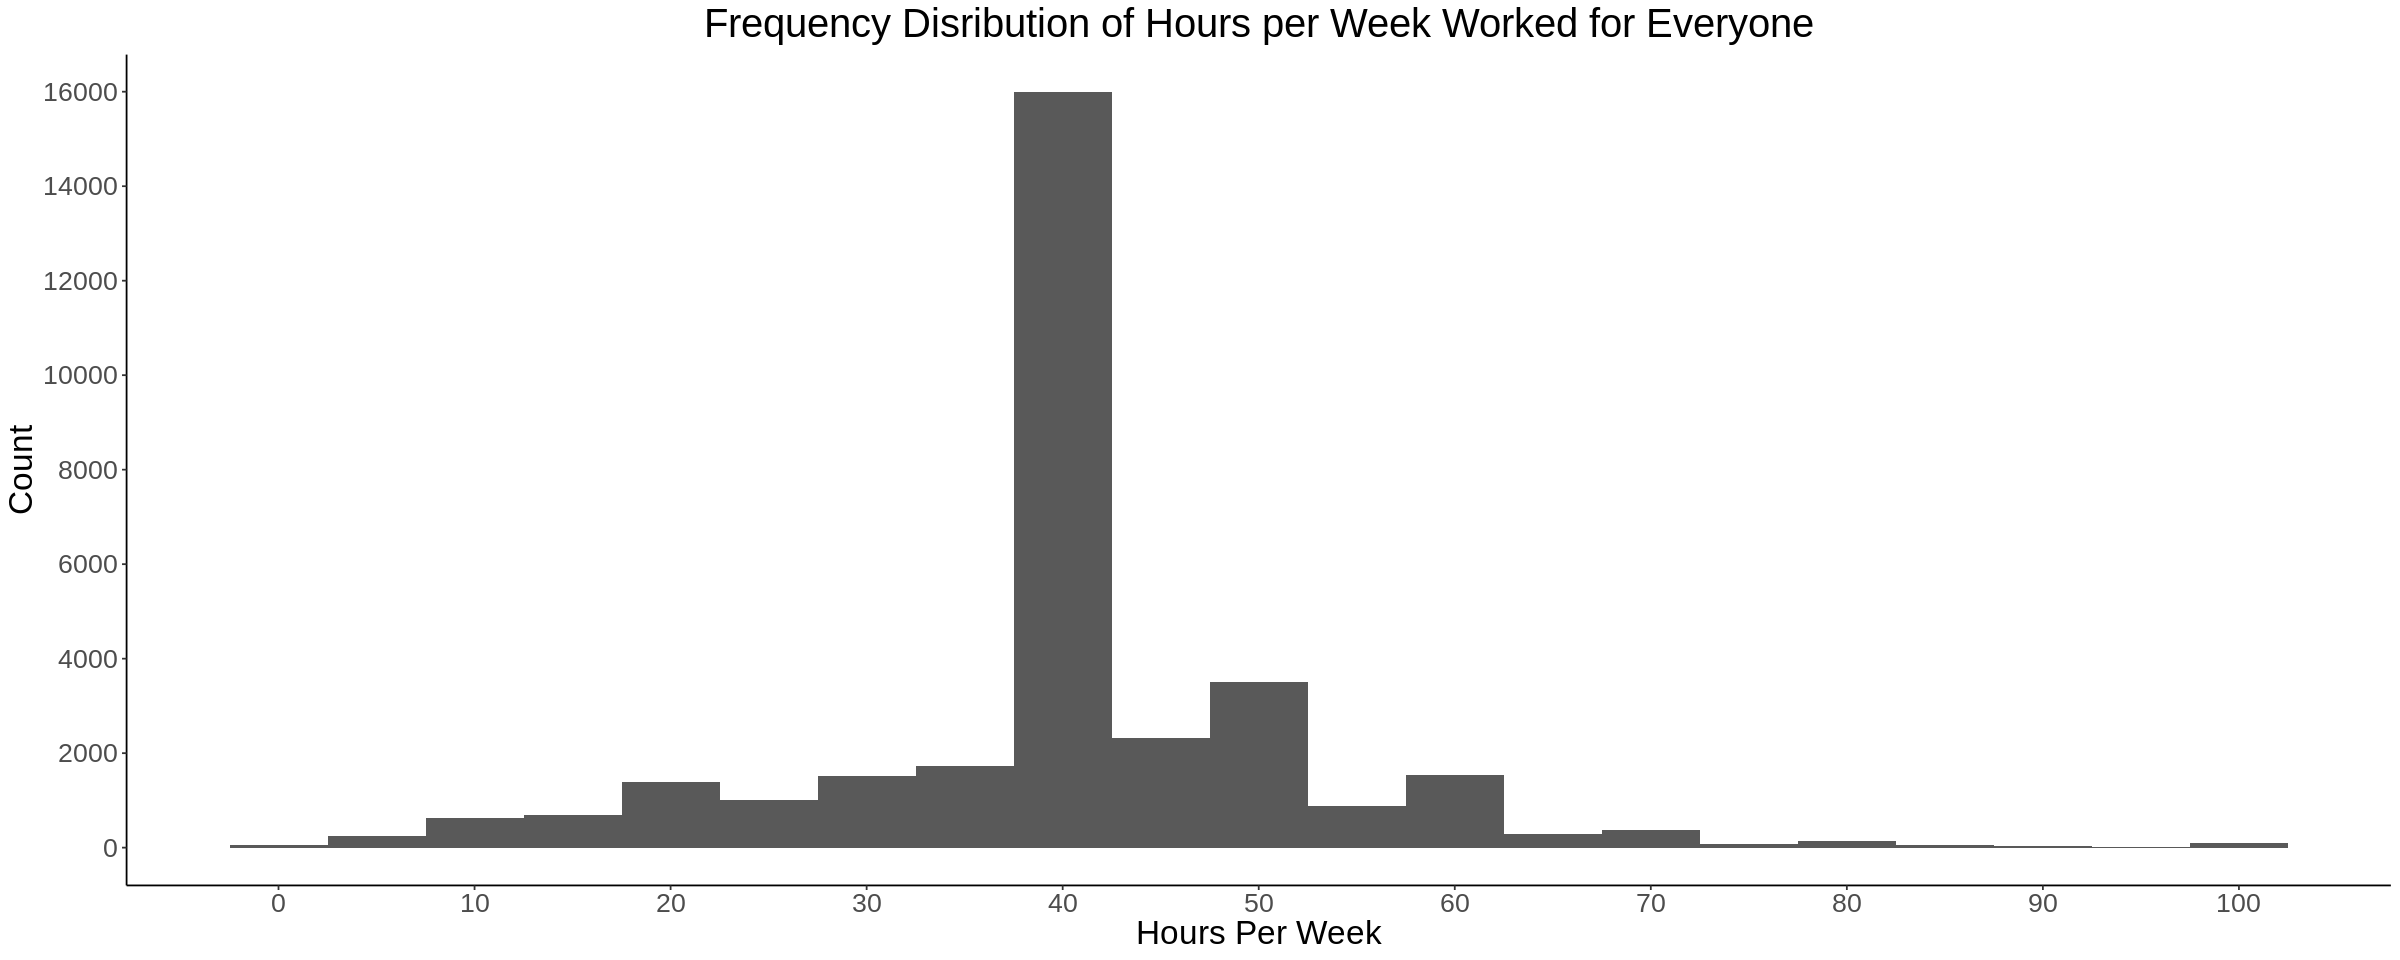

In [9]:
hrs_per_week_all

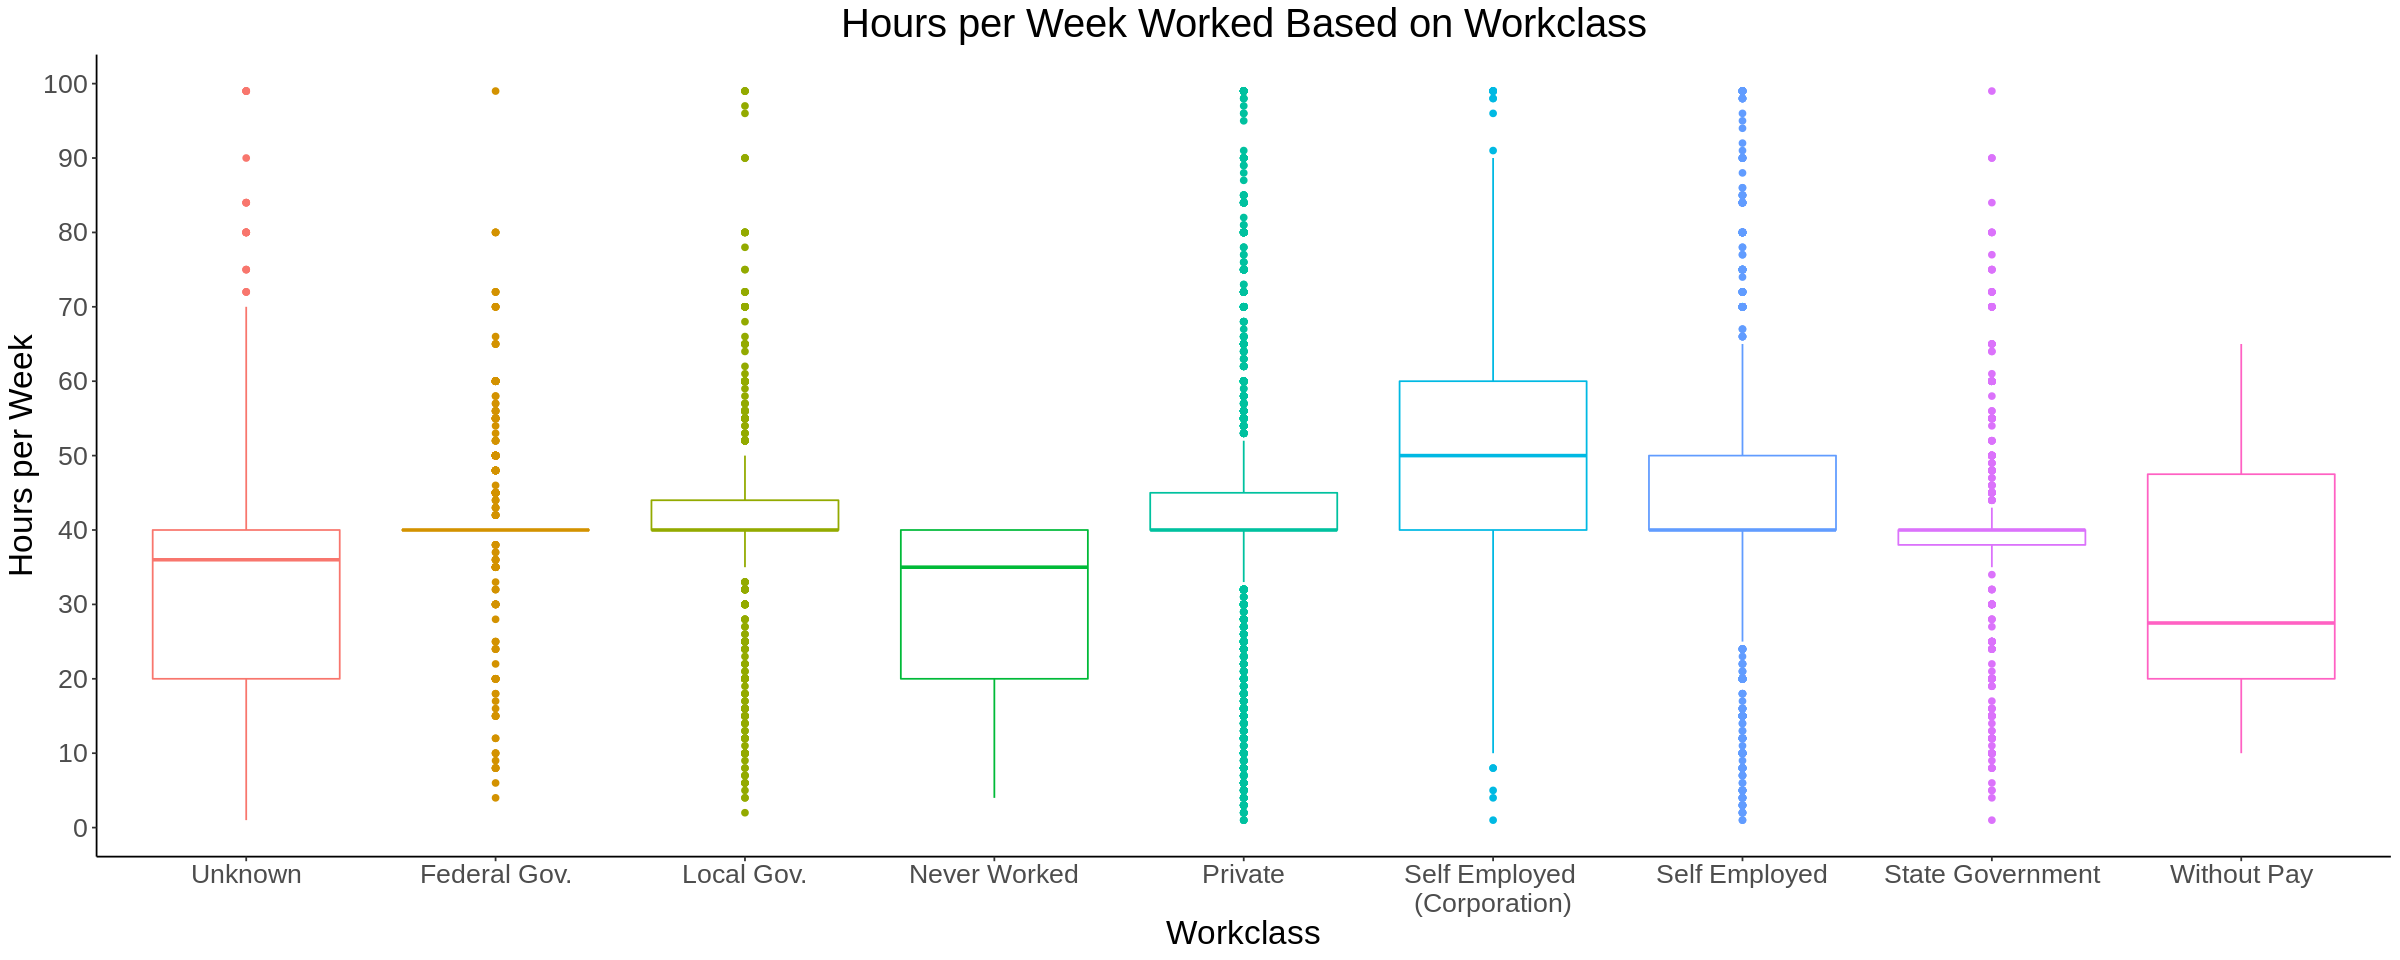

In [10]:
hrs_per_week_workclass

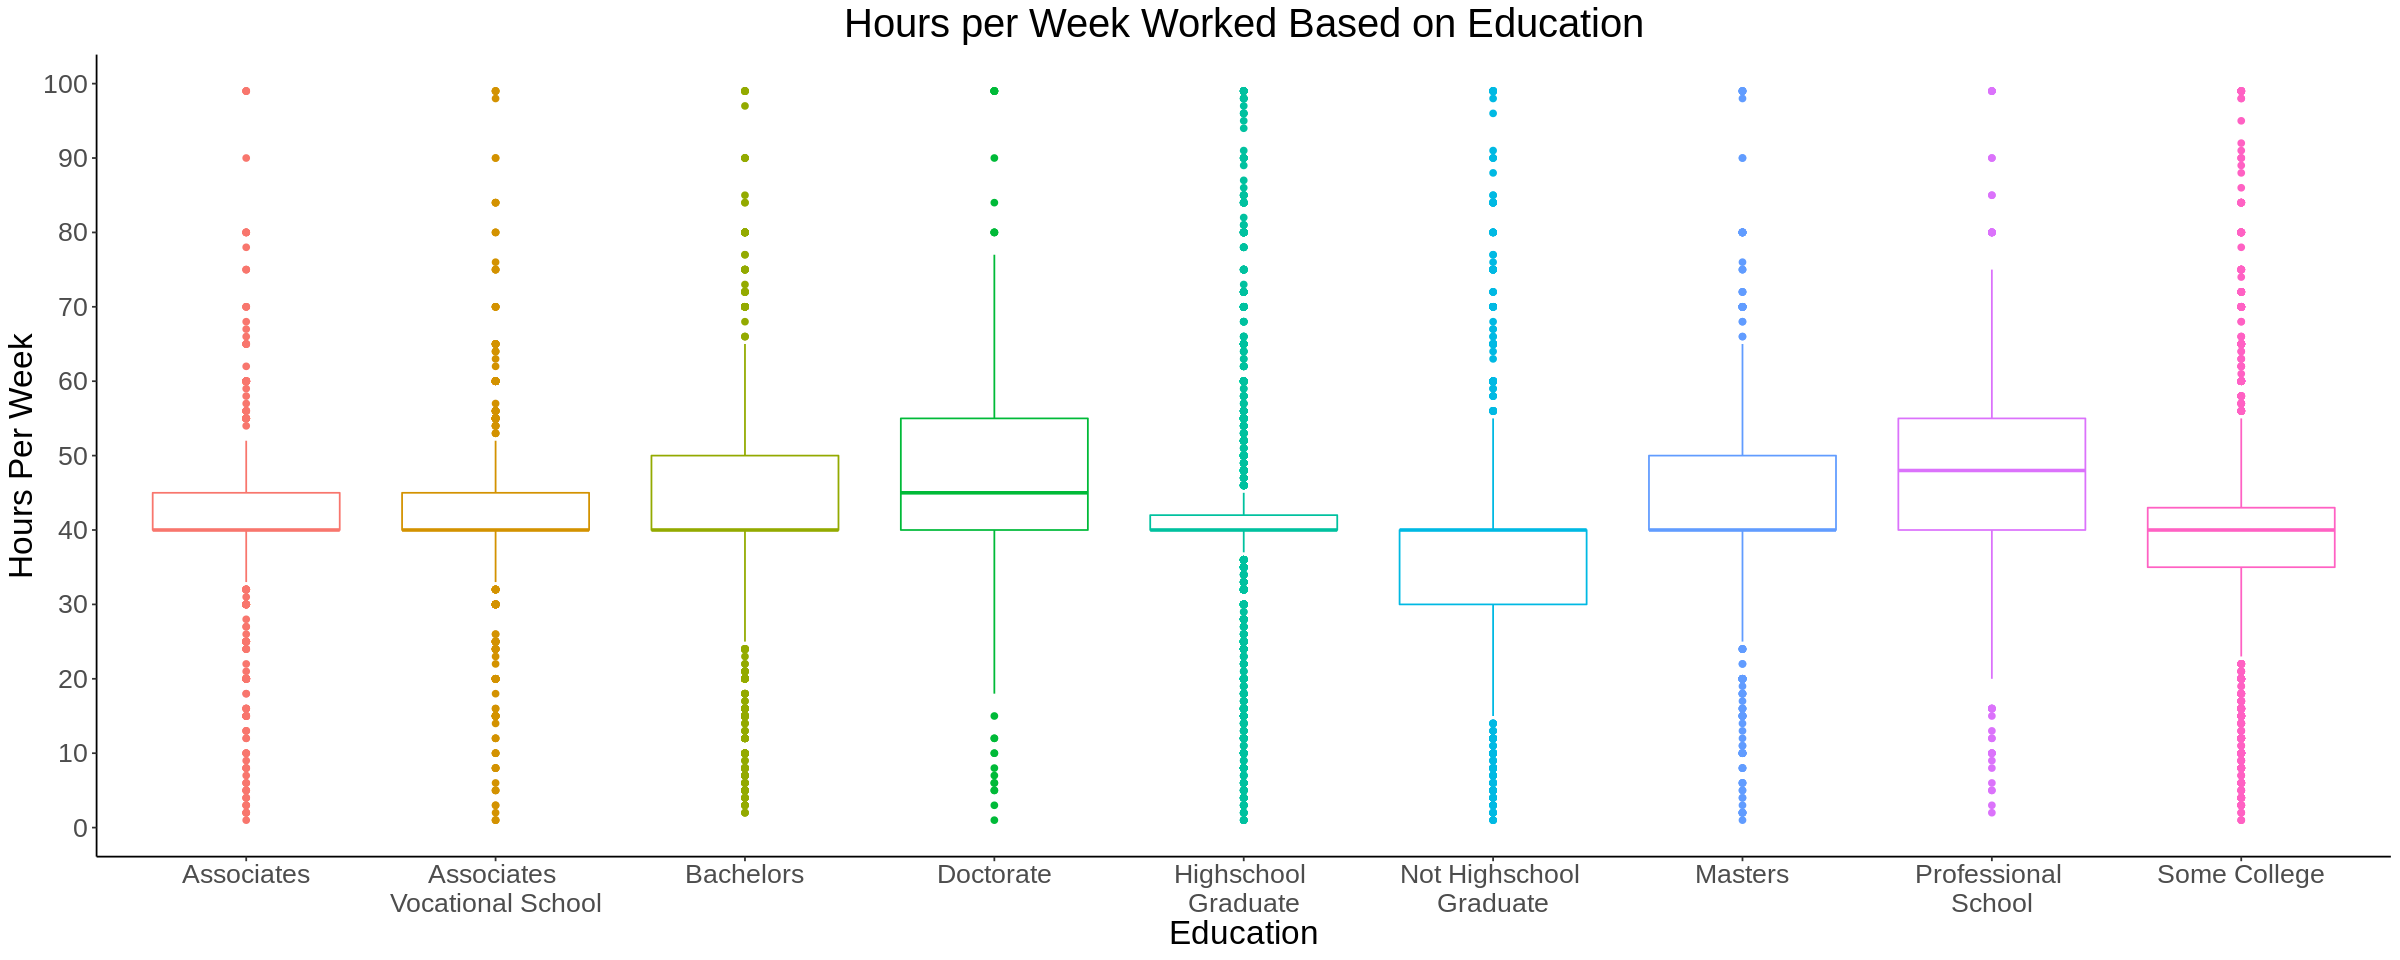

In [11]:
hrs_per_week_education

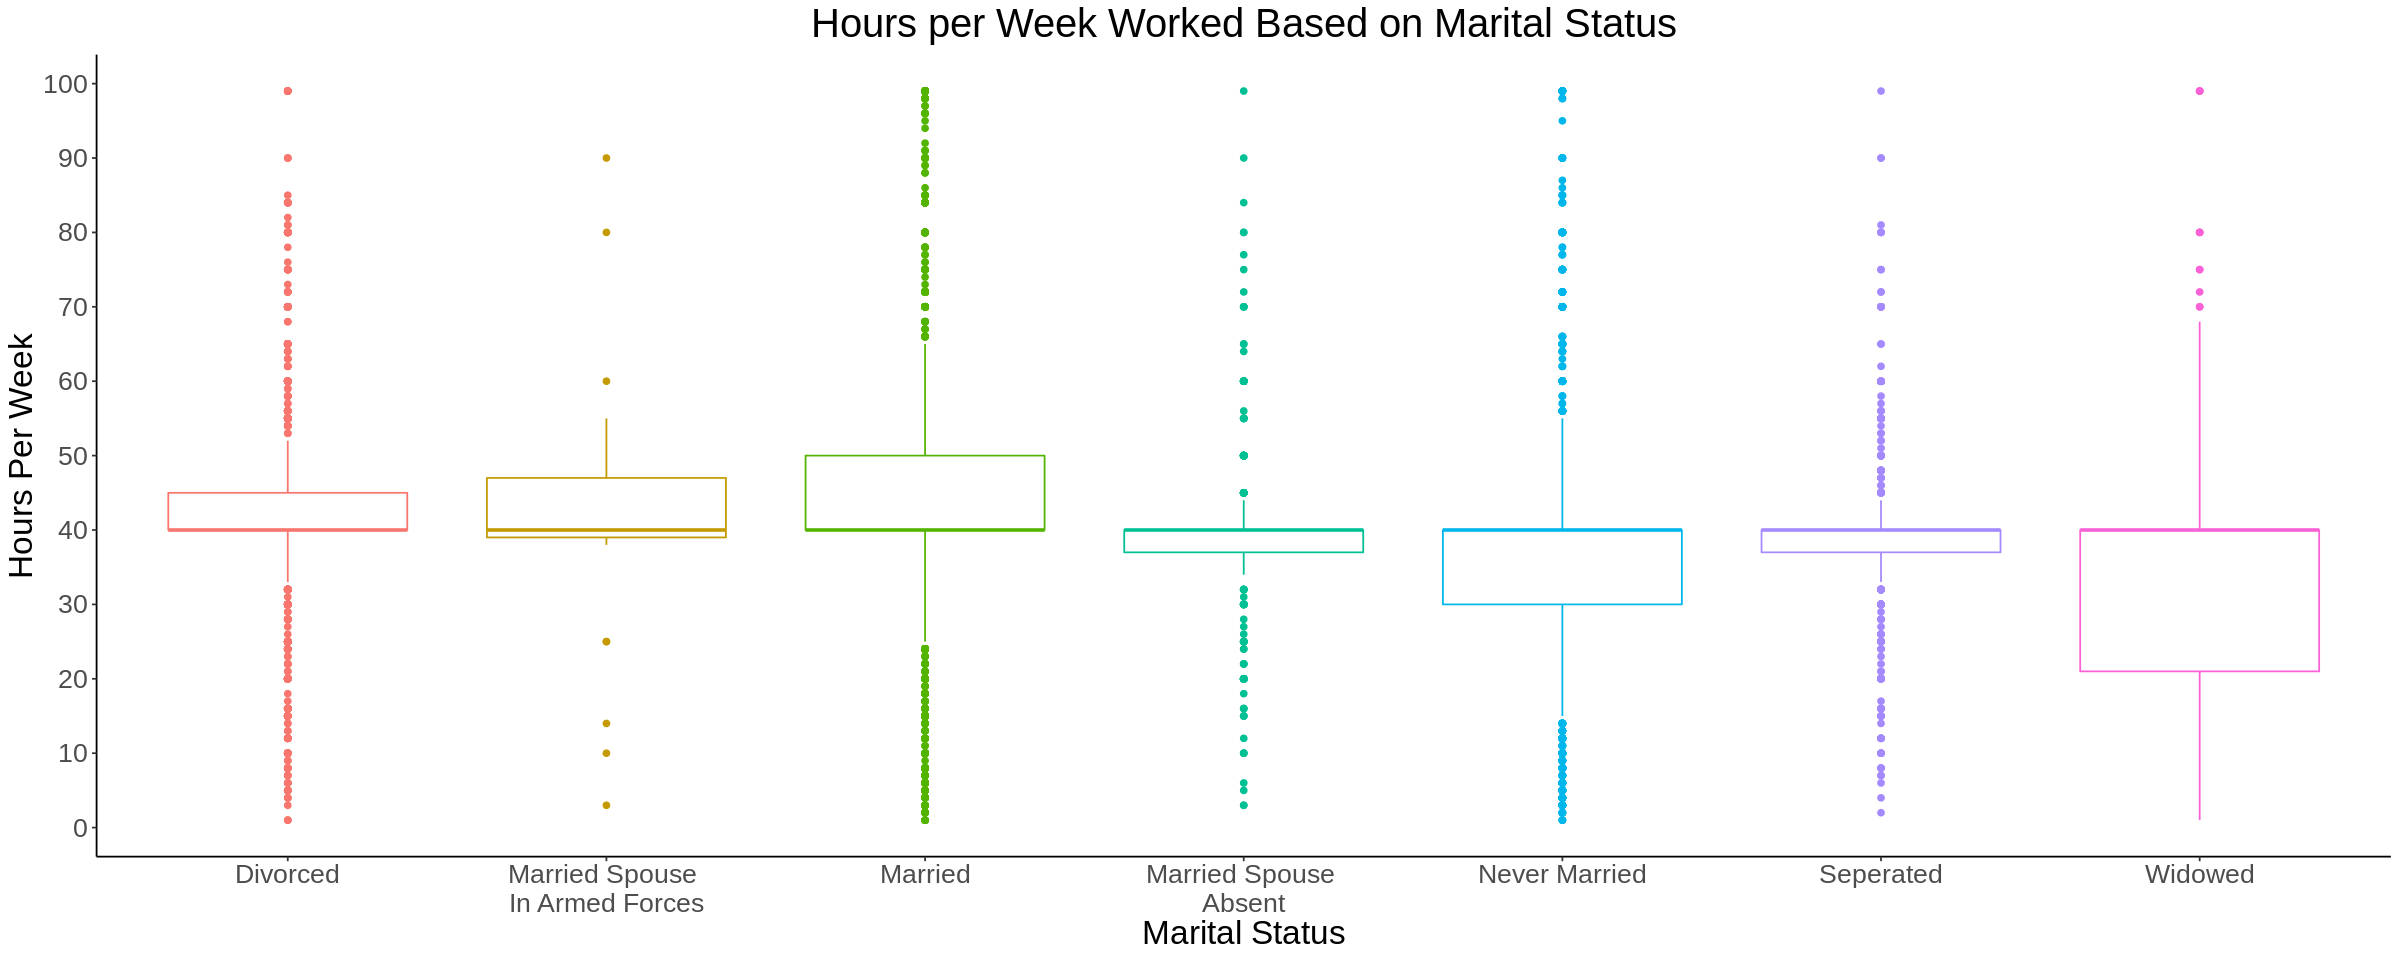

In [12]:
hrs_per_week_marital_status

### Statistics of Our Dataset

In [13]:
hrs_work_class <- data %>%
    group_by(work_class) %>%
    summarise(mean_hours_per_week = mean(hours_per_week),
             sd_hours_per_week = sd(hours_per_week))

hrs_education <- data %>%
    group_by(education) %>%
    summarise(mean_hours_per_week = mean(hours_per_week),
             sd_hours_per_week = sd(hours_per_week))

hrs_marital_status <- data %>%
    group_by(marital_status) %>%
    summarise(mean_hours_per_week = mean(hours_per_week),
             sd_hours_per_week = sd(hours_per_week))

**Mean Hours Worked Based on Workclass and Standard Deviation**

In [14]:
hrs_work_class

work_class,mean_hours_per_week,sd_hours_per_week
<chr>,<dbl>,<dbl>
?,31.91939,14.909903
Federal-gov,41.37917,8.838605
Local-gov,40.98280,10.771559
Never-worked,28.42857,15.186147
Private,40.26710,11.256298
Self-emp-inc,48.81810,13.900417
Self-emp-not-inc,44.42188,16.674958
State-gov,39.03159,11.697014
Without-pay,32.71429,17.357900


**Mean Hours Worked Based on Education Level and Standard Deviation**

In [15]:
hrs_education

education,mean_hours_per_week,sd_hours_per_week
<chr>,<dbl>,<dbl>
Assoc-acdm,40.50422,12.19667
Assoc-voc,41.61071,10.79338
Bachelors,42.61401,11.44619
Doctorate,46.97337,15.08445
HS-grad,40.57537,11.33376
Less-than-HS,36.71785,13.34644
Masters,43.83633,12.27780
Prof-school,47.42535,14.80604
Some-college,38.85228,12.76190


**Mean Hours Worked Based on Marital Status and Standard Deviation**

In [16]:
hrs_marital_status

marital_status,mean_hours_per_week,sd_hours_per_week
<chr>,<dbl>,<dbl>
Divorced,41.24668,10.67663
Married-AF-spouse,41.13043,19.44060
Married-civ-spouse,43.28486,11.90505
Married-spouse-absent,39.66986,11.76737
Never-married,36.94000,12.43254
Separated,39.30146,10.37753
Widowed,32.97986,14.05869


In [46]:
bar_means_hrs_work_class <- hrs_work_class %>%
    ggplot(aes(x = work_class, y = mean_hours_per_week, fill = work_class)) +
    geom_bar(stat = "identity") +
    xlab("Work Class") +
    ylab("Mean Hours Worked") +
    ggtitle("Mean Hours Worked For Each Work Class") +
    plot_config +
    workclass_labels

bar_means_hrs_education <- hrs_education %>%
    ggplot(aes(x = education, y = mean_hours_per_week, fill = education)) +
    geom_bar(stat = "identity") +
    xlab("Education Level") +
    ylab("Mean Hours Worked") +
    ggtitle("Mean Hours Worked For Each Education Level") +
    plot_config +
    education_labels

bar_means_marital_status <- hrs_marital_status %>%
    ggplot(aes(x = marital_status, y = mean_hours_per_week, fill = marital_status)) +
    geom_bar(stat = "identity") +
    xlab("Marital Status") +
    ylab("Mean Hours Worked") +
    ggtitle("Mean Hours Worked Based on Marital Status") +
    plot_config +
    marital_status_labels

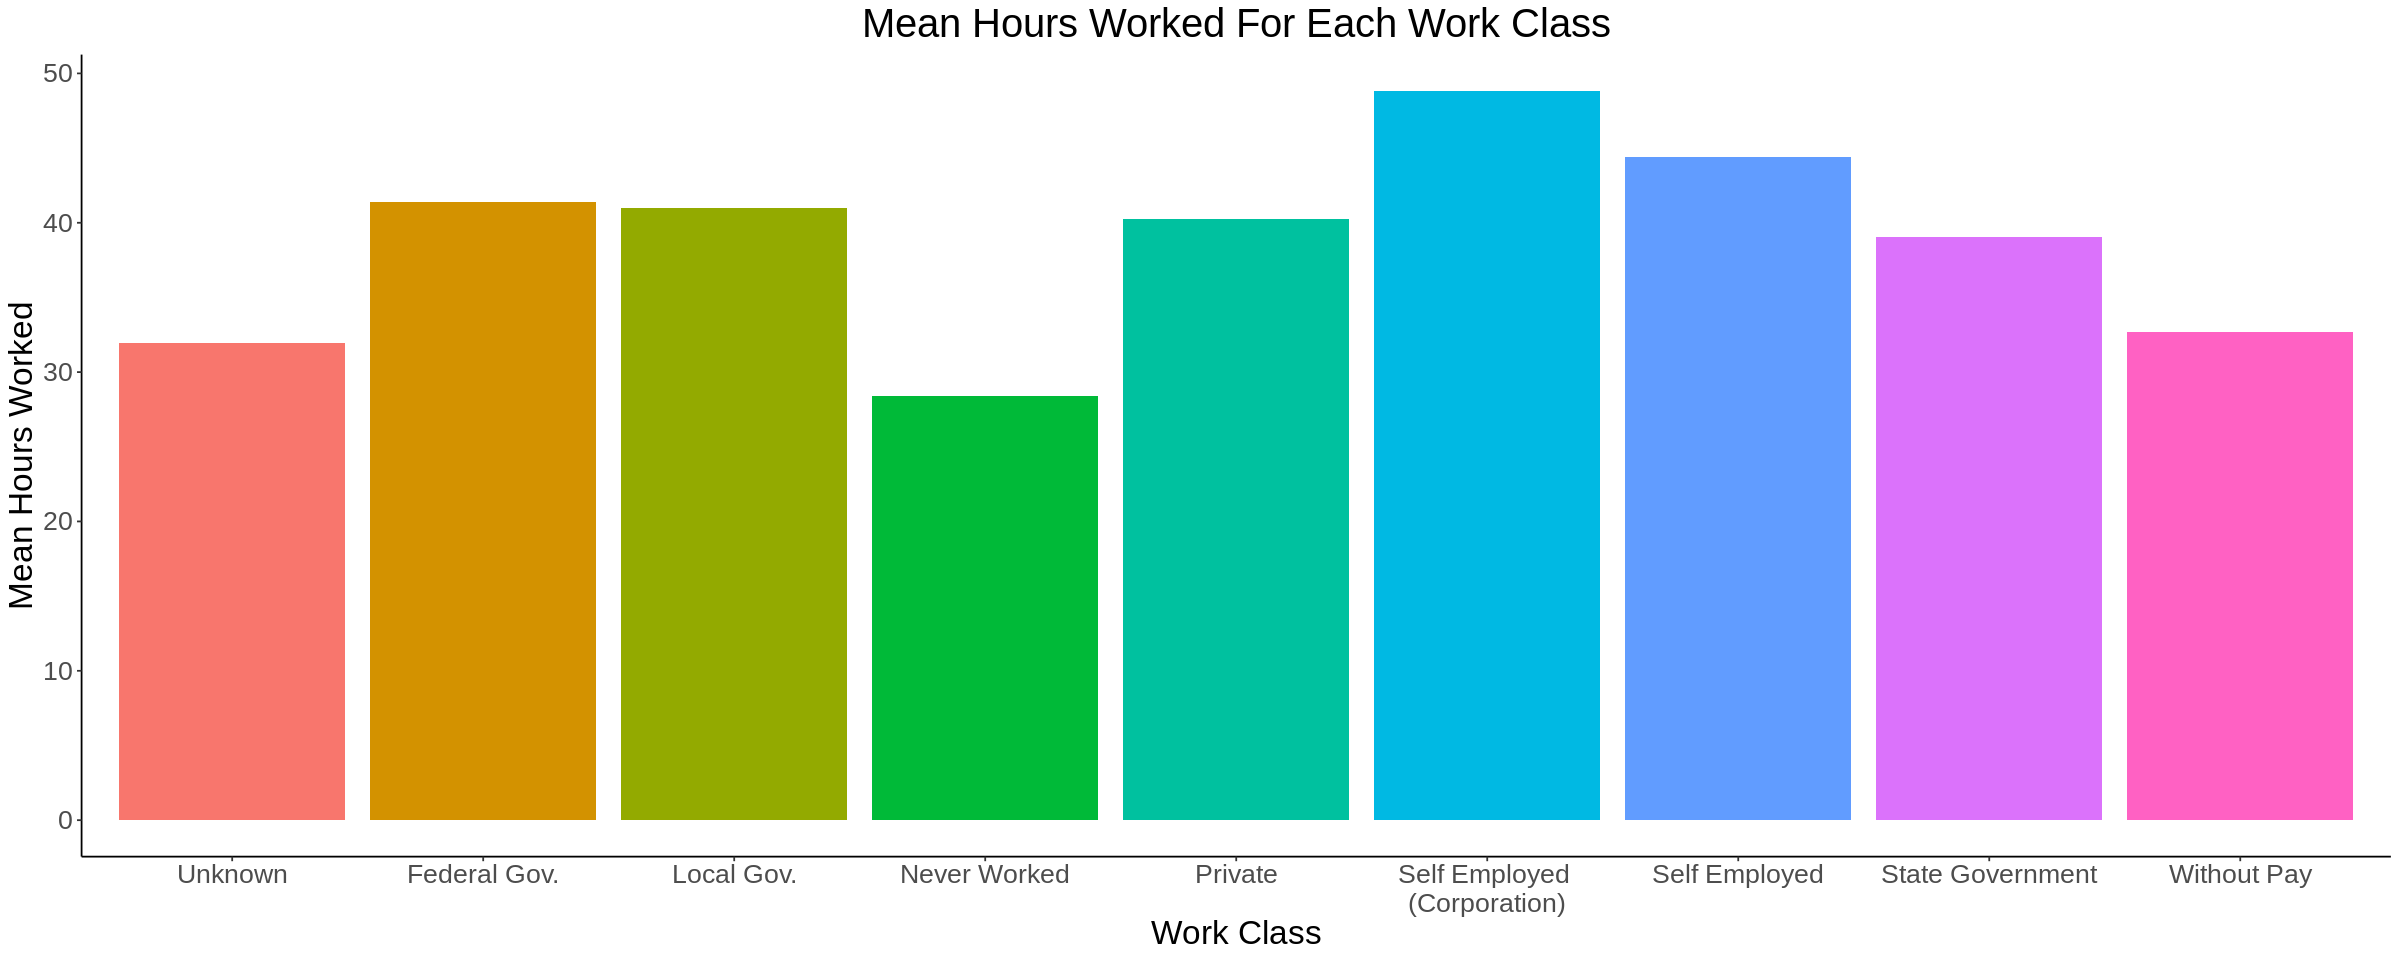

In [47]:
bar_means_hrs_work_class

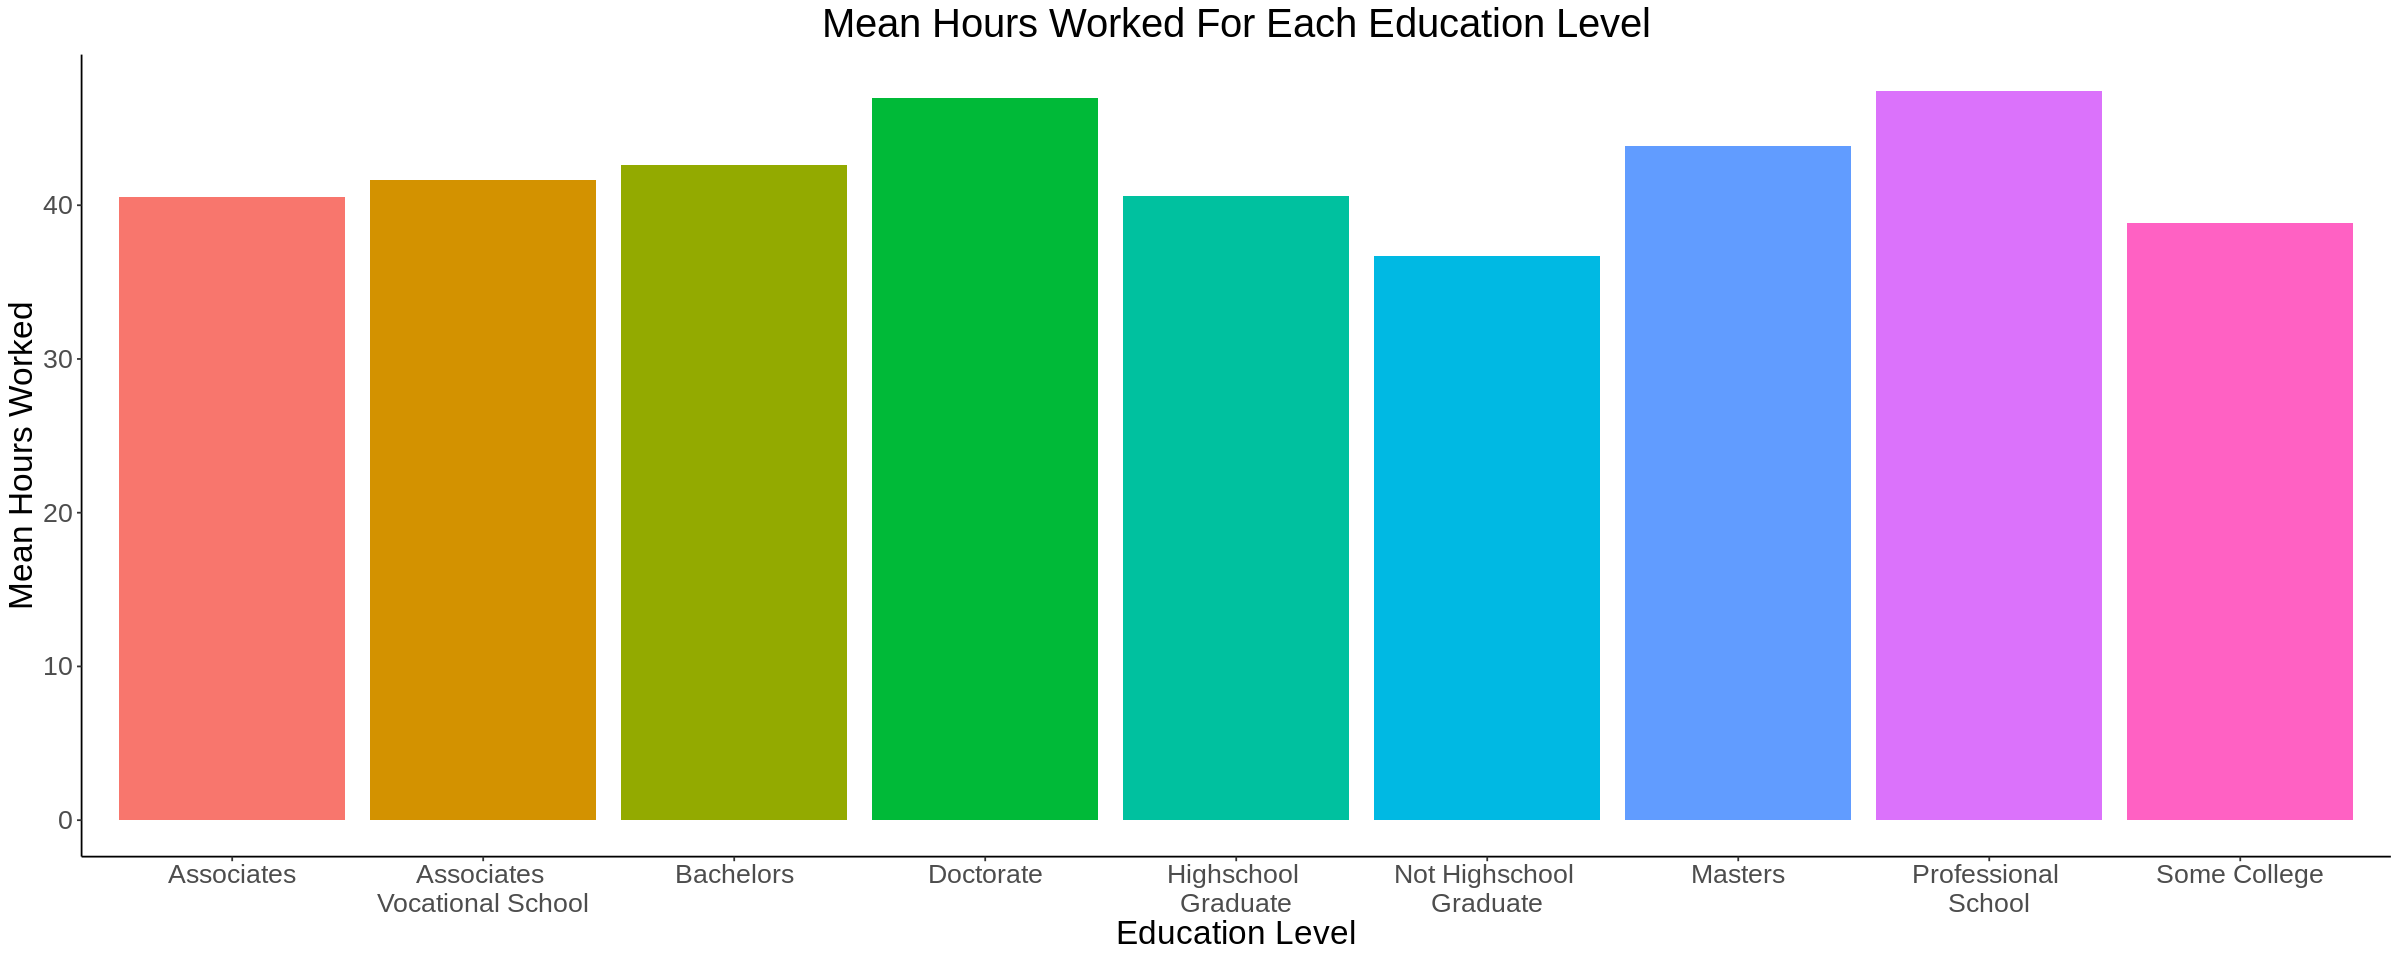

In [48]:
bar_means_hrs_education

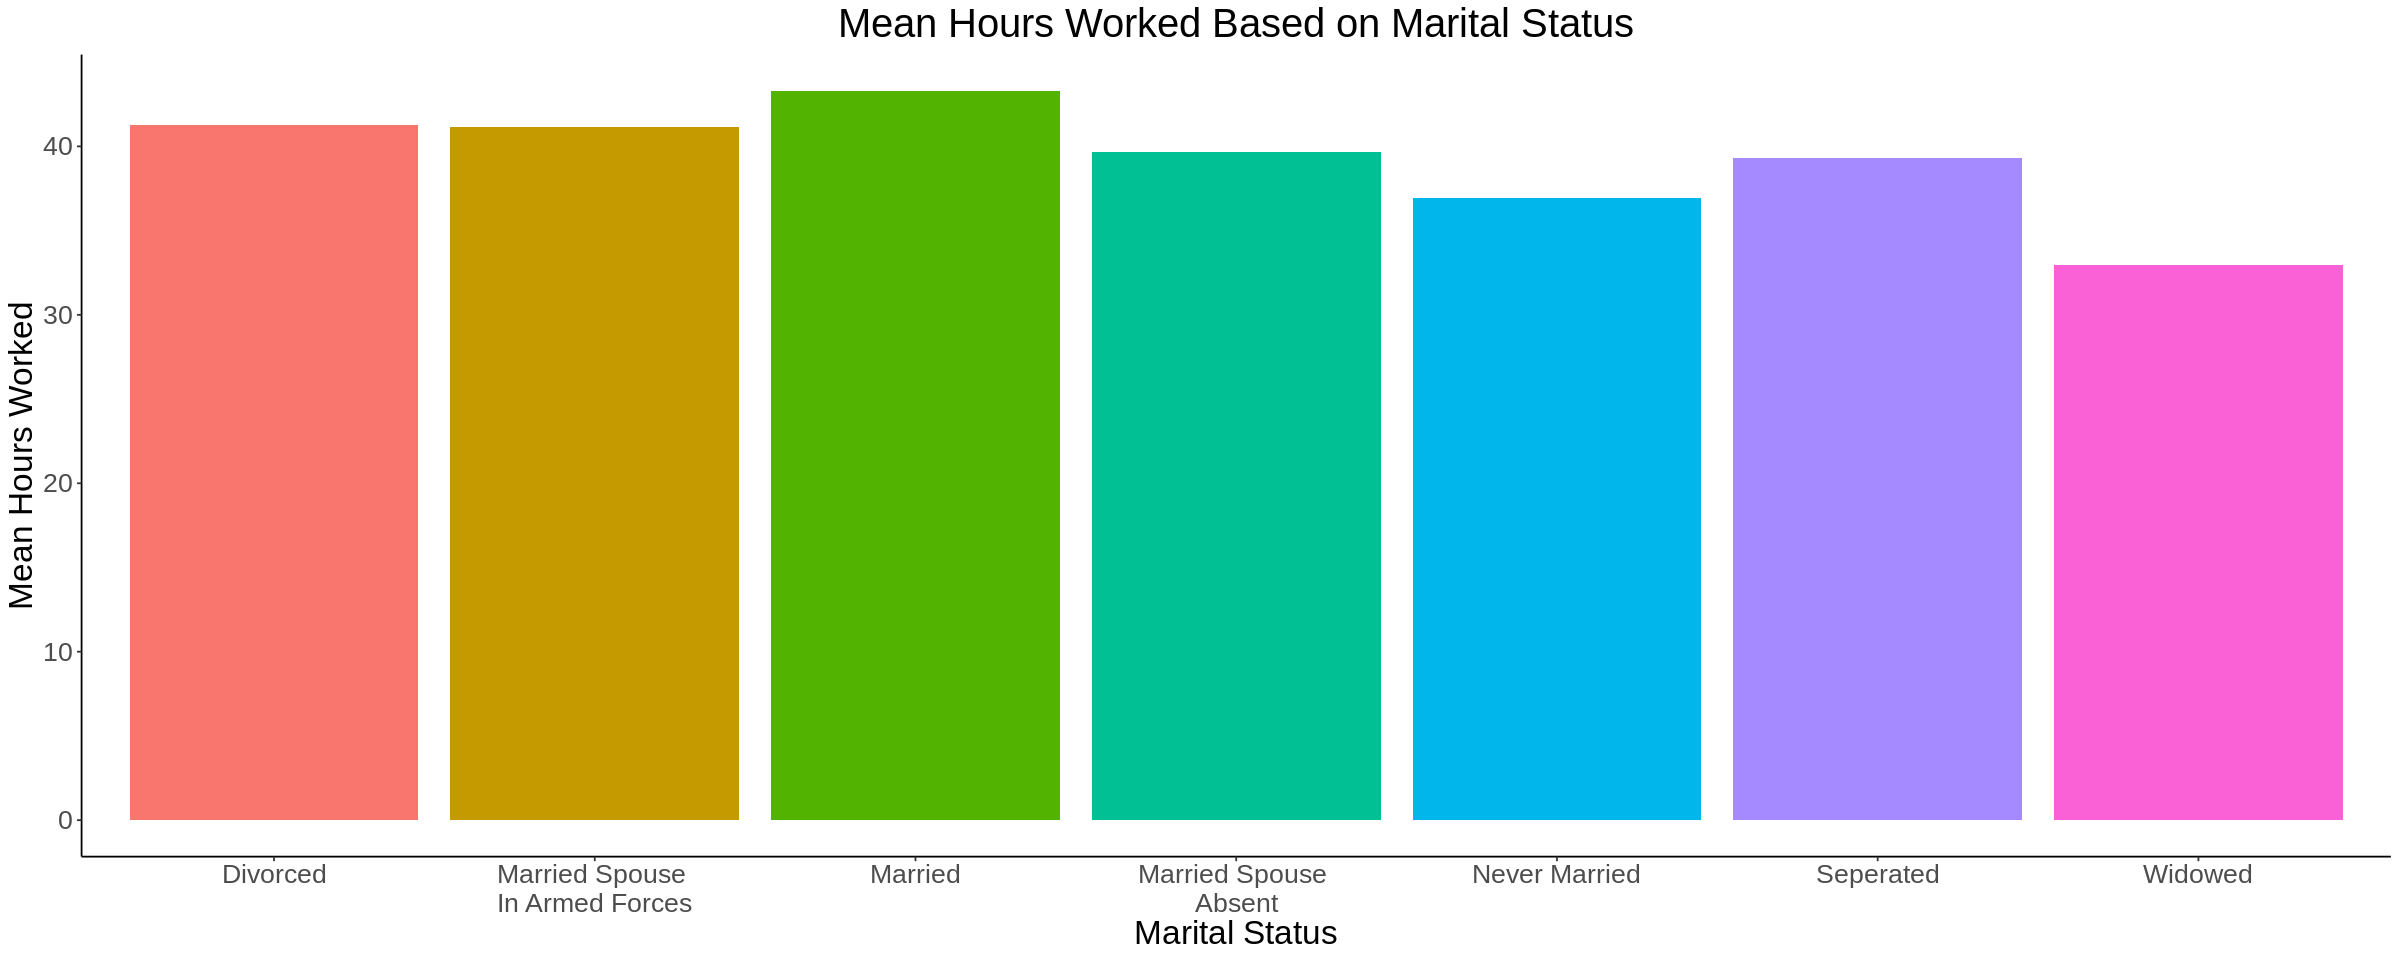

In [49]:
bar_means_marital_status

# Hypothesis Tests & Confidence Intervals

### Testing Mean Working Hours Based on Education Level

We will be further studying how the mean work hours of people with an education less than highschool compares to those with more than highschool. To conduct this test, we are going to do a one sample t-test to see if those that have a higher education work more hours compared to those that do not.

We had already created a "Less-than-HS" group in our preliminary results section, so below we are just creating another group called "More-than-HS" and putting all the observations that are not in "Less-than-HS" into that group.

In [50]:
data_ed <- data

data_ed$education[data_ed$education == "Assoc-acdm" |
               data_ed$education == "Assoc-voc" |
               data_ed$education == "Bachelors" |
               data_ed$education == "Doctorate" |
               data_ed$education == "HS-grad" |
               data_ed$education == "Masters" |
               data_ed$education == "Prof-school" |
               data_ed$education == "Some-college"] = "More-than-HS"
compare_hour_low_hi <- data_ed |> 
    group_by(education) |> 
    summarize(mean_hours_per_week=mean(hours_per_week)) |>
    pull()

less_than_hs_mean <- compare_hour_low_hi[1]
more_than_hs_mean <- compare_hour_low_hi[2]

education_hour_table <- data_ed |> 
    select(education,hours_per_week)

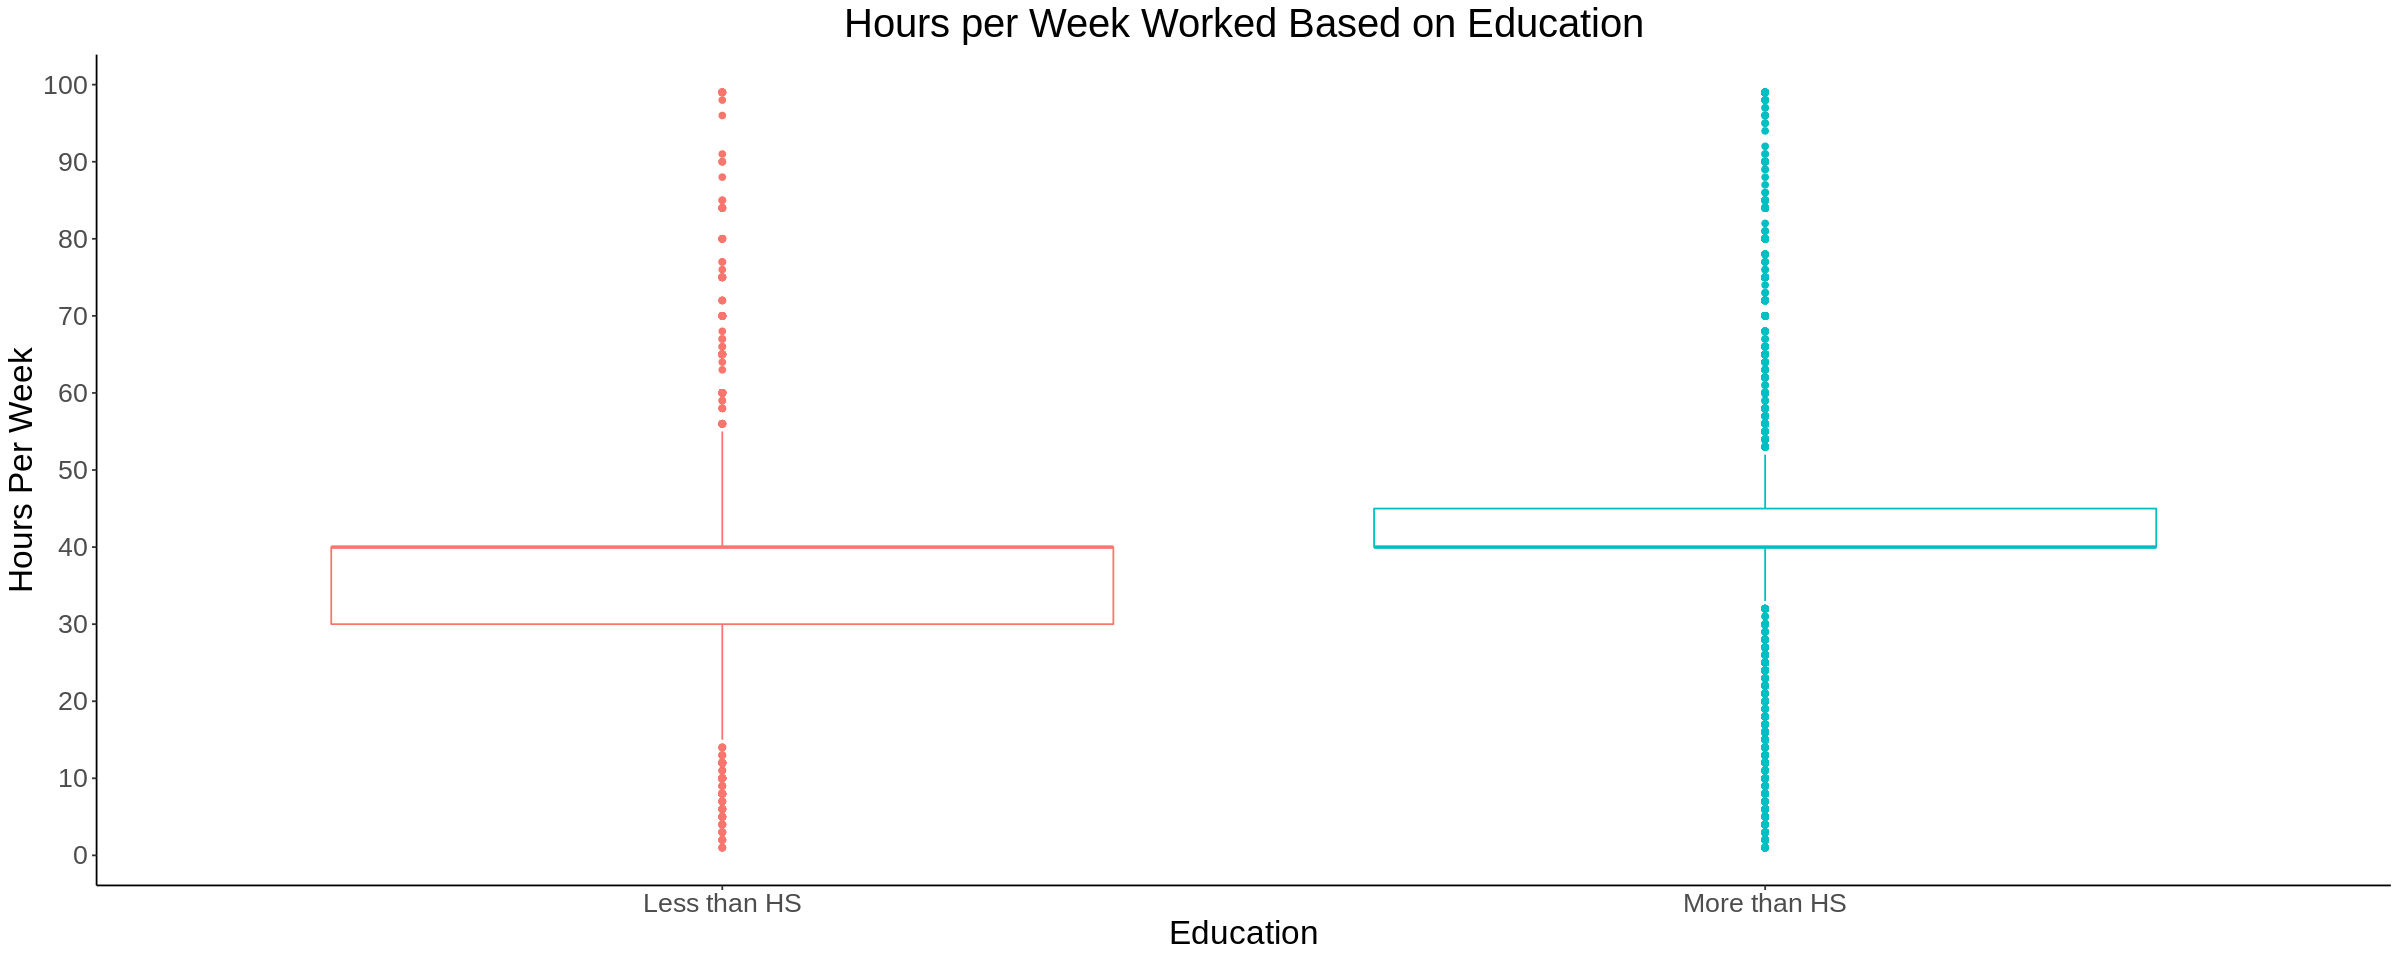

In [51]:
education_hour_box_plot <- education_hour_table %>%
    ggplot(aes(x = education, y = hours_per_week, color = education)) +
    geom_boxplot() +
    xlab("Education") +
    ylab("Hours Per Week") +
    ggtitle("Hours per Week Worked Based on Education") +
    plot_config +
    boxplot_scale +
    scale_x_discrete(labels = c("Less than HS", "More than HS"))
education_hour_box_plot

**Bootstraping Method**

Now we will be using bootstrapping to create a final dataframe that we can use in our test

ci_lower,ci_upper
<dbl>,<dbl>
39.4939,41.3241


ci_lower,ci_upper
<dbl>,<dbl>
35.1319,36.9886


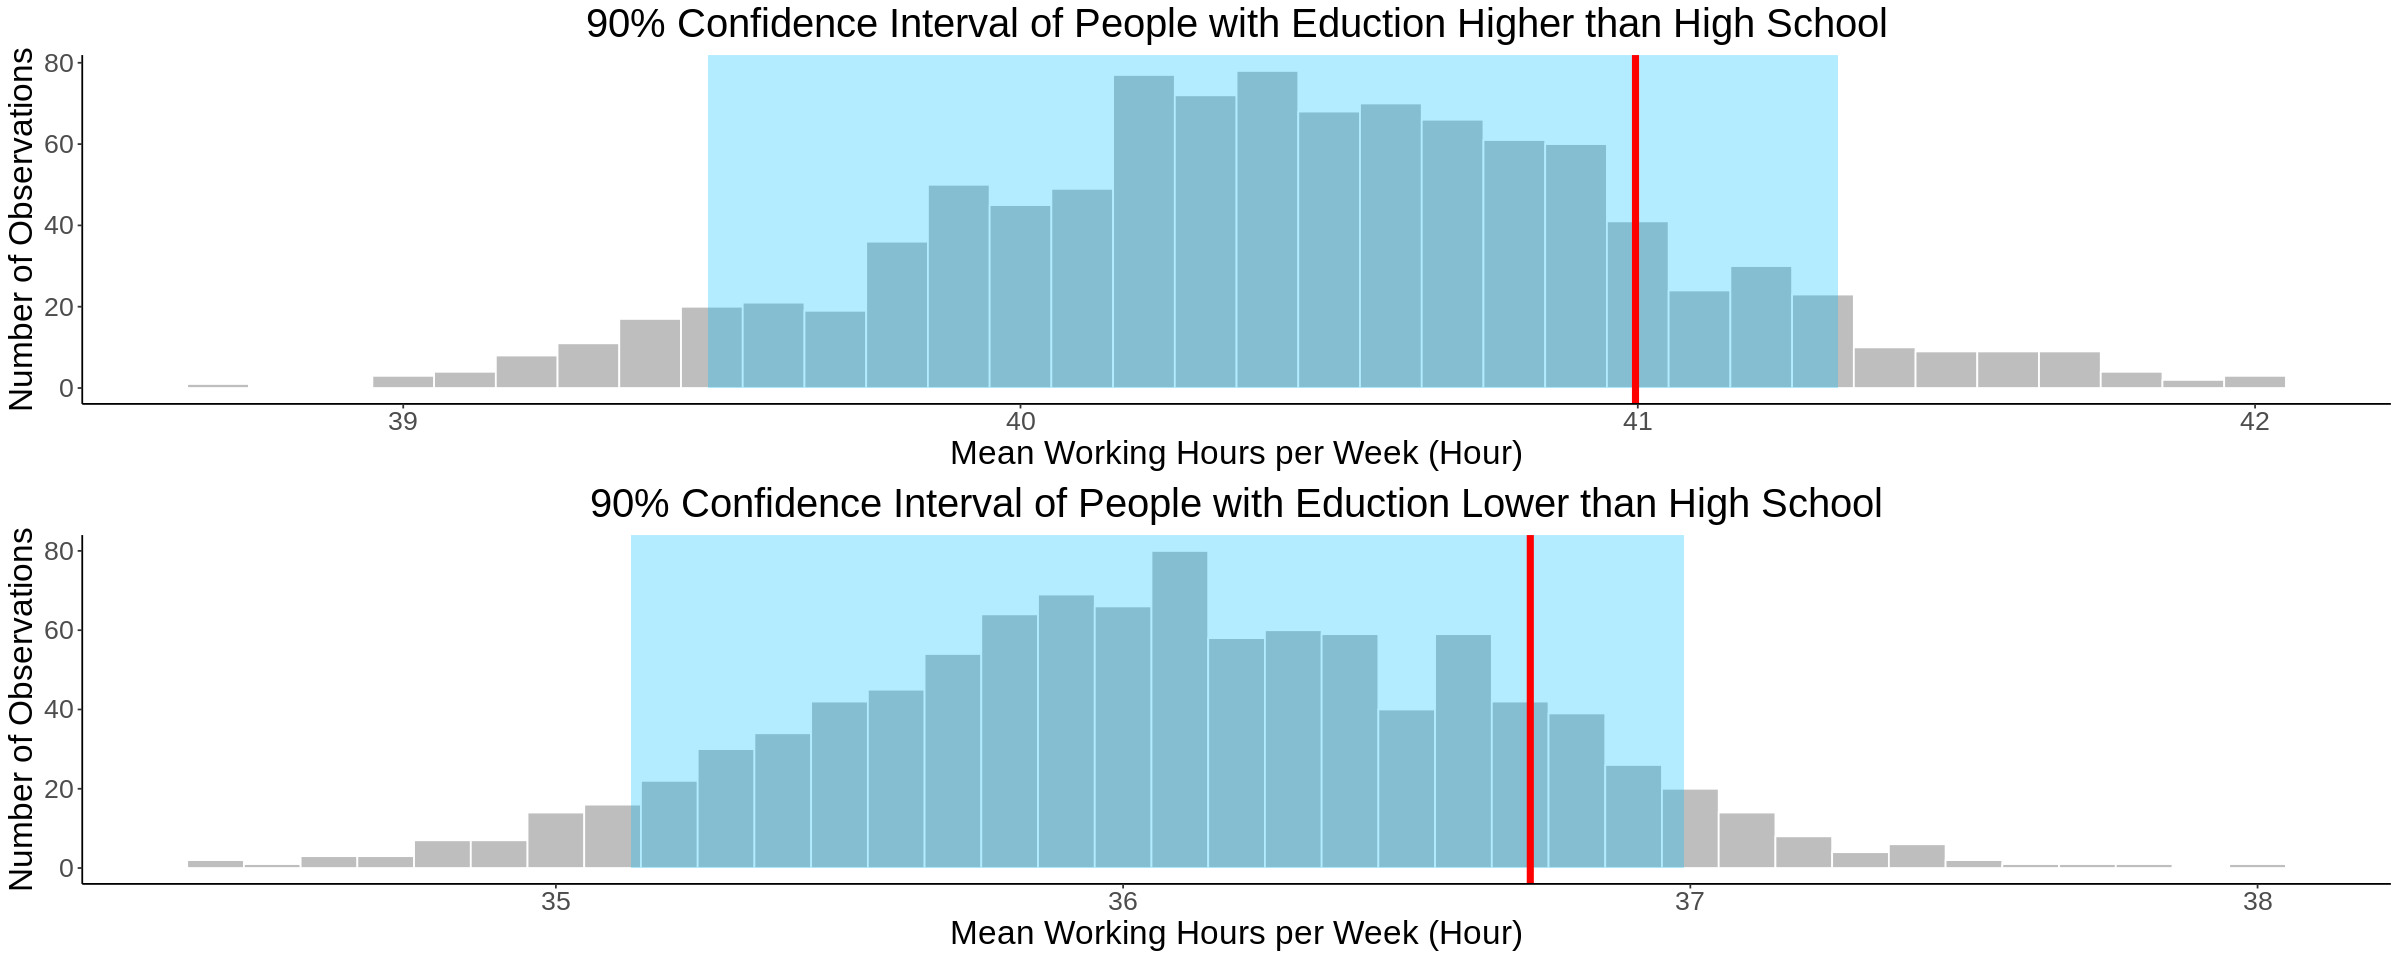

In [52]:
set.seed(50)
more_than_high_school_sample_1 <- education_hour_table |> 
    filter(education == "More-than-HS") |> 
    rep_sample_n(reps = 1, size = 500, replace = FALSE) |> 
    ungroup() |> 
    select(hours_per_week)
bootstrap_dist_1 <- more_than_high_school_sample_1 |>
    rep_sample_n(reps= 1000, size = 500, replace = TRUE) |> 
    group_by(replicate) |> 
    summarize(mean_working_hour = mean(hours_per_week)) |> 
    select(mean_working_hour)
mean_more_than_h_school <- bootstrap_dist_1 |>
    mutate(education = "More-than-HS")

ci_1 <- bootstrap_dist_1 |> 
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_1
ci_plot_1 <- 
    bootstrap_dist_1 %>% 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_1$ci_lower, xmax = ci_1$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = more_than_hs_mean,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People with Eduction Higher than High School",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config

lower_than_high_school_sample_1 <- education_hour_table |> 
    filter(education == "Less-than-HS") |> 
    rep_sample_n(reps = 1, size = 500, replace = FALSE) |> 
    ungroup() |> 
    select(hours_per_week)
bootstrap_dist_2 <- lower_than_high_school_sample_1 |>
    rep_sample_n(reps= 1000, size = 500, replace = TRUE) |> 
    group_by(replicate) |> 
    summarize(mean_working_hour = mean(hours_per_week)) |> 
    select(mean_working_hour)

mean_less_than_h_school <- bootstrap_dist_2 |>
    mutate(education = "Less-than-HS")

ci_2 <- bootstrap_dist_2 |> 
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_2
ci_plot_2 <- 
    bootstrap_dist_2 %>% 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_2$ci_lower, xmax = ci_2$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = less_than_hs_mean,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People with Eduction Lower than High School",
         x = "Mean Working Hours per Week (Hour)",
        y = "Number of Observations") +
    plot_config

plot_grid(ci_plot_1, ci_plot_2, nrow = 2)

**Explanation**

From the plot above, there is a 90% confidence that the true mean working hour per week for people who with education that higher than high school is between 39.4939 and 41.3241, which also indicate that our observed statistic is fall in that arrange. Also, there is a 90% confidence that the true mean working hour per week for people who with education that higher than less school is between 35.1319 and 36.9886, which also indicate that our observed statistic is fall in that arrange. 

**Asymptotic Method**

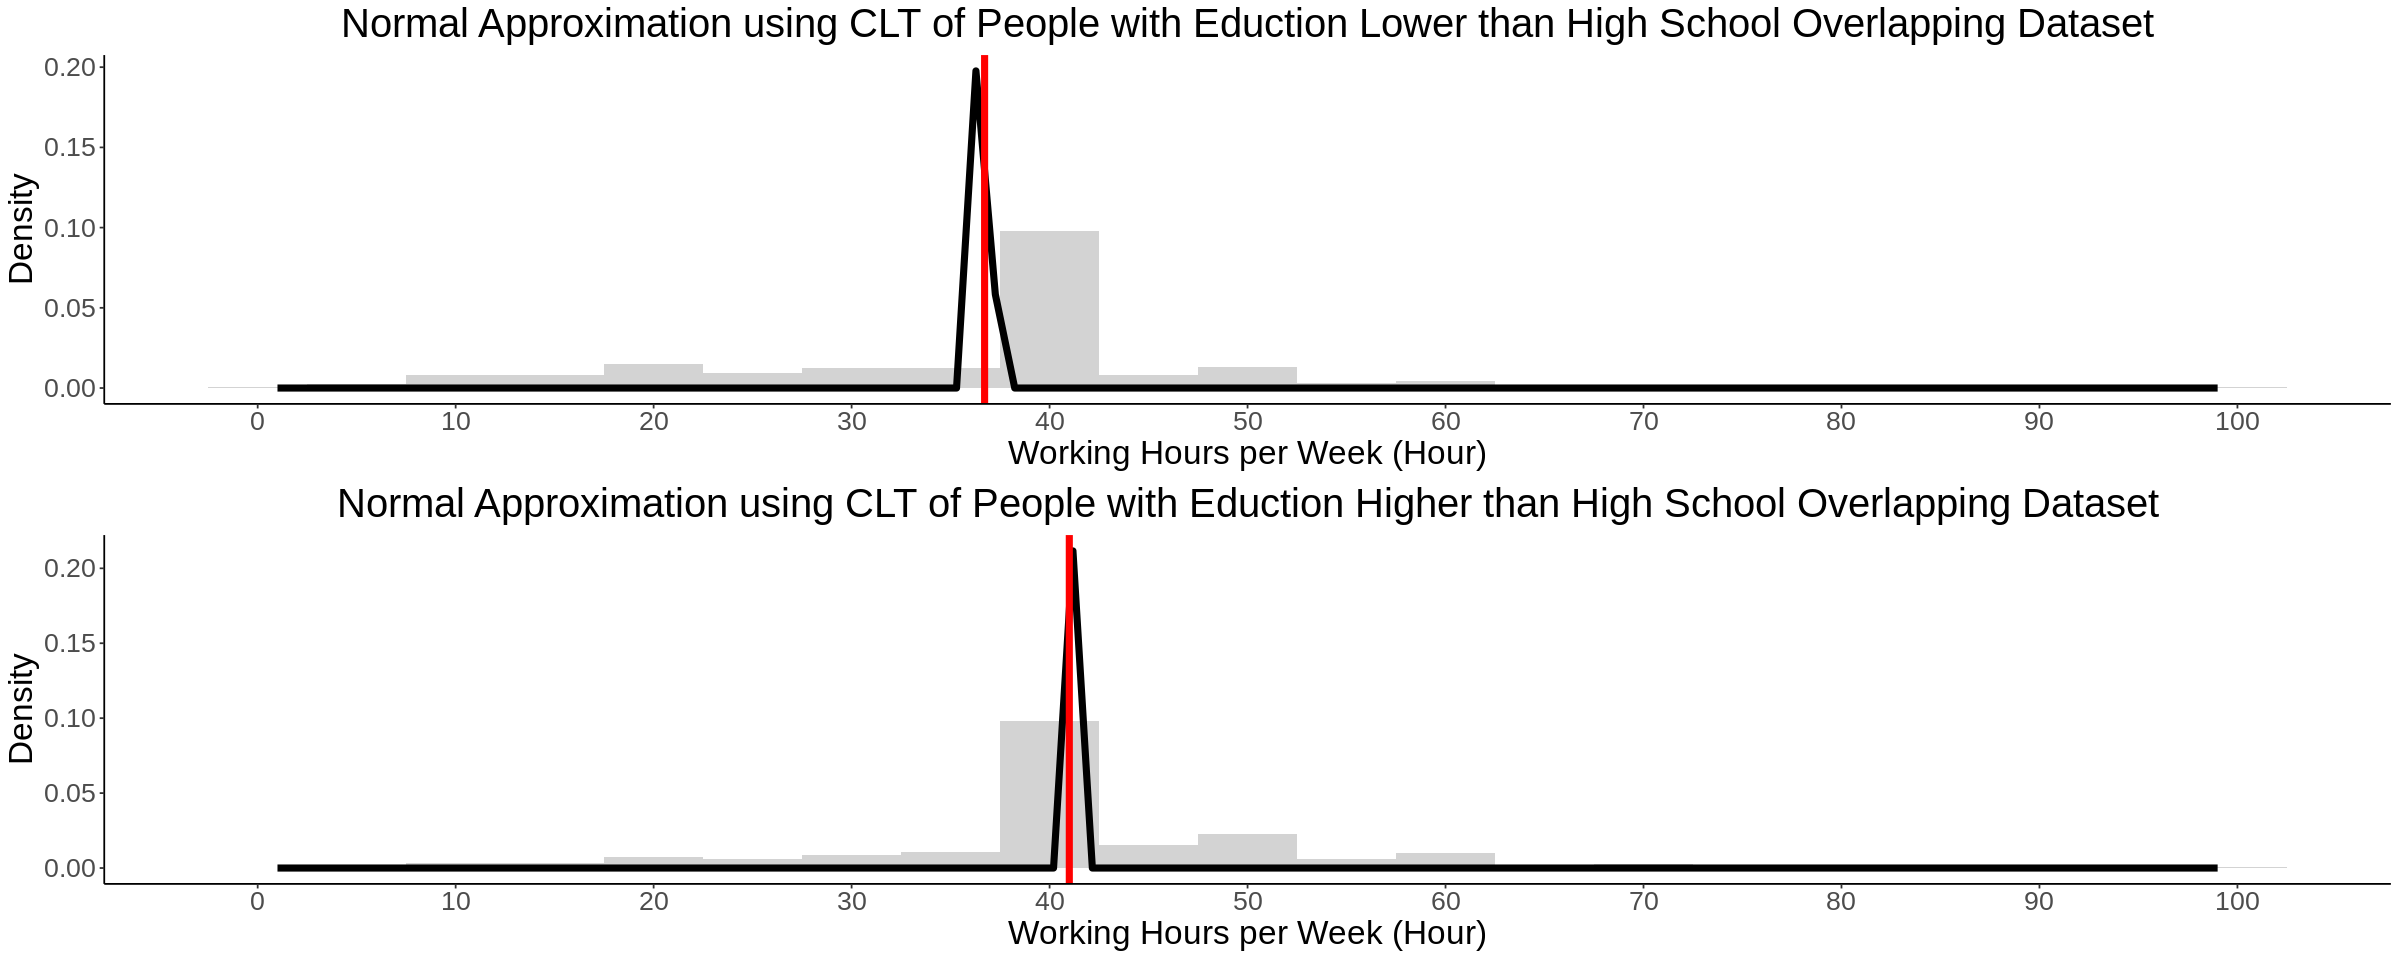

In [40]:
# CLT states, as n -> inf, X ~ Norm(mean, sd/sqrt(n))

more_hs = data_ed %>%
    filter(education == "More-than-HS")

more_hs_plot <- more_hs %>% 
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y =..density..), fill = "lightgray", binwidth = 5) +
    labs(title = "Normal Approximation using CLT of People with Eduction Higher than High School Overlapping Dataset",
         x = "Working Hours per Week (Hour)",
         y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(more_hs$hours_per_week),
                                           sd = sd(more_hs$hours_per_week) / sqrt(nrow(more_hs))),
                 color = "black", size = 2) +
    plot_config +
    scale_x_continuous(breaks = seq(0, 100, 10)) +
    geom_vline(xintercept = mean(more_hs$hours_per_week),
               size = 2,
               colour = "red")

less_hs = data %>%
    filter(education == "Less-than-HS")

less_hs_plot <- less_hs %>% 
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y =..density..), fill = "lightgray", binwidth = 5) +
    labs(title = "Normal Approximation using CLT of People with Eduction Lower than High School Overlapping Dataset",
         x = "Working Hours per Week (Hour)",
         y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(less_hs$hours_per_week),
                                           sd = sd(less_hs$hours_per_week) / sqrt(nrow(less_hs))),
                 color = "black", size = 2) +
    plot_config +
    scale_x_continuous(breaks = seq(0, 100, 10)) +
    geom_vline(xintercept = mean(less_hs$hours_per_week),
               size = 2,
               colour = "red")

plot_grid(less_hs_plot, more_hs_plot, nrow = 2)



**90% Confidence Interval for Asymptotic Method of People with Eduction Higher than High School**

In [42]:
tibble("Mean" = mean(more_hs$hours_per_week),
               "Lower" = qnorm(0.025, mean(more_hs$hours_per_week), sd(more_hs$hours_per_week) / sqrt(nrow(more_hs))),
               "Upper" = qnorm(0.95 + 0.025, mean(more_hs$hours_per_week), sd(more_hs$hours_per_week) / sqrt(nrow(more_hs))))


Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
40.99629,40.85543,41.13715


**Explanation**

From the plot above, there is a 90% confidence that the true mean working hour per week for people who with education that higher than high school is between 40.85543 and 41.13715, which also indicate that our observed statistic is fall in that arrange.

**90% Confidence Interval for Asymptotic Method of People with Eduction Lower than High School**

In [43]:
tibble("Mean" = mean(less_hs$hours_per_week),
               "Lower" = qnorm(0.025, mean(less_hs$hours_per_week), sd(less_hs$hours_per_week) / sqrt(nrow(less_hs))),
               "Upper" = qnorm(0.95 + 0.025, mean(less_hs$hours_per_week), sd(less_hs$hours_per_week) / sqrt(nrow(less_hs))))


Mean,Lower,Upper
<dbl>,<dbl>,<dbl>
36.71785,36.31673,37.11896


**Explanation**

there is a 90% confidence that the true mean working hour per week for people who with education that higher than less school is between 36.31673 and 37.11896, which also indicate that our observed statistic is fall in that arrange. 

**Hypothesis Testing**

- $H_0$ : difference between mean of average working hours per week of More-than-HS people and Less-than-HS are 0
- $H_A$ : difference between mean of average working hours per week of More-than-HS people and Less-than-HS are greater than 0

`summarise()` has grouped output by 'replicate'. You can override using the `.groups` argument.



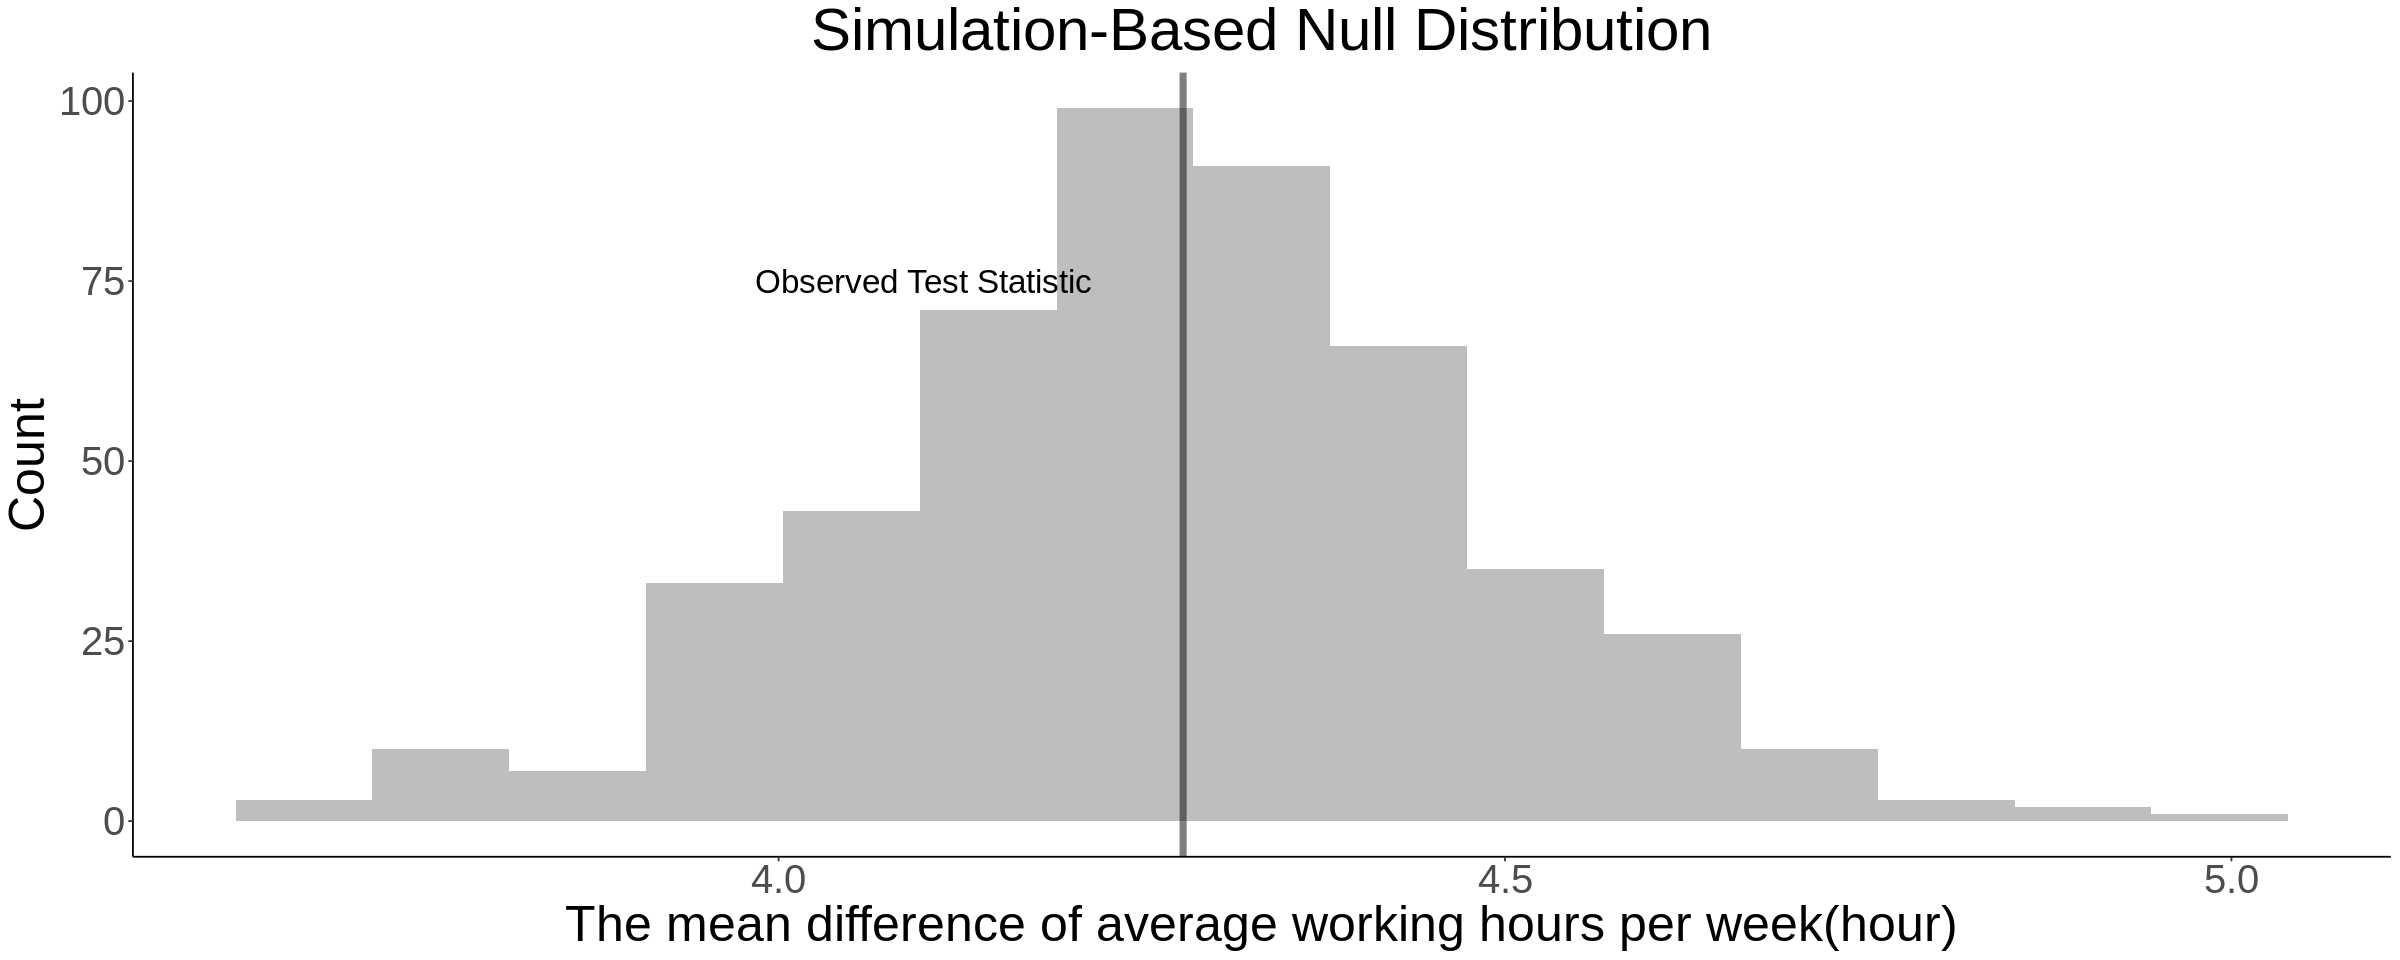

In [33]:
bootstrapping_sample <- education_hour_table |> 
    rep_sample_n(size=32561, reps= 500, replace=TRUE) |>
    group_by(replicate,education) |>
    summarize(mean=mean(hours_per_week)) |>
    group_by(replicate) |>
    mutate(stat = mean-lag(mean)) |>
    select(replicate,stat) |>
    filter(!is.na(stat))
observed_statistic <- education_hour_table |> 
    specify(hours_per_week ~ education) |> 
    calculate(stat = "diff in means", order = c("More-than-HS","Less-than-HS")) |>
    pull()

null_model_plot <-bootstrapping_sample |>
    ggplot(aes(x=stat))+
    geom_histogram(bins = 15, fill="grey")+
    geom_vline(xintercept = observed_statistic, color = "black", alpha=.5, lwd=2)+
    annotate("text", x = 4.1, y = 75, label = "Observed Test Statistic", color="Black", size=7)+
    plot_config +
    labs(x = "The mean difference of average working hours per week(hour)", y = "Count") +
    theme(text = element_text(size=30))+
    ggtitle("Simulation-Based Null Distribution")
null_model_plot


**P-Value**

In [35]:
p_value <- mean(bootstrapping_sample$stat > observed_statistic)
p_value

[1] 0.484

**Since the p-value is greater than the significant level, we are fail to reject the Null Hypothesis, which mean there is not enough evidence to show that the alternative Hypothesis is correct.**

### Mean Working Hours Based on Marital Status

When looking at marital status, we want to see if being married affects the number of hours a person spends at work. Ideally, we want to compare those that are married but not living with their spouse (they are either seperated, spouse is in the military or spouse is absent) vs married vs not married (divorced, never married, widowed). To conduct this test, we are going to use the Welch ANOVA method because we are comparing more than two independent groups and our groups have different variances.

In [14]:
data_ms <- data

data_ms$marital_status[data_ms$marital_status == "Separated" |
                          data_ms$marital_status == "Married-spouse-absent" |
                          data_ms$marital_status == "Married-AF-spouse"] = "Married-Not-Together"

data_ms$marital_status[data_ms$marital_status == "Married-civ-spouse"] = "Married"

data_ms$marital_status[data_ms$marital_status == "Never-married" |
                       data_ms$marital_status == "Widowed" |
                       data_ms$marital_status == "Divorced"] = "Not-Married"


**Bootstrapping Method**

In [15]:
data_ms %>% group_by(marital_status) %>% summarise(n = n())
compare_hour_low_hi_marital <- data_ms |> 
    group_by(marital_status) |> 
    summarize(mean_hours_per_week=mean(hours_per_week)) |>
    pull()
married_mean_s <- compare_hour_low_hi_marital[1]
married_nt_mean_s <- compare_hour_low_hi_marital[2]
not_married_s <- compare_hour_low_hi_marital[3]

marital_status,n
<chr>,<int>
Married,14976
Married-Not-Together,1466
Not-Married,16119


In [ ]:
married_bootstrap <- data_ms %>%
    filter(marital_status == "Married") %>%
    rep_sample_n(reps= 1000, size = 14976, replace = TRUE)

married_nt__bootstrap <- data_ms %>%
    filter(marital_status == "Married-Not-Together") %>%
    rep_sample_n(reps= 1000, size = 1466, replace = TRUE)

not_married_bootstrap <- data_ms %>%
    filter(marital_status == "Not-Married") %>%
    rep_sample_n(reps= 1000, size = 16119, replace = TRUE)

In [21]:
married_mean <- married_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(marital_status = "Married") %>%
    select(marital_status, mean_working_hour)
married_nt__mean <- married_nt__bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(marital_status = "Married Not Together") %>%
    select(marital_status, mean_working_hour)
not_married_mean <- not_married_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(marital_status = "Not Married") %>%
    select(marital_status, mean_working_hour)

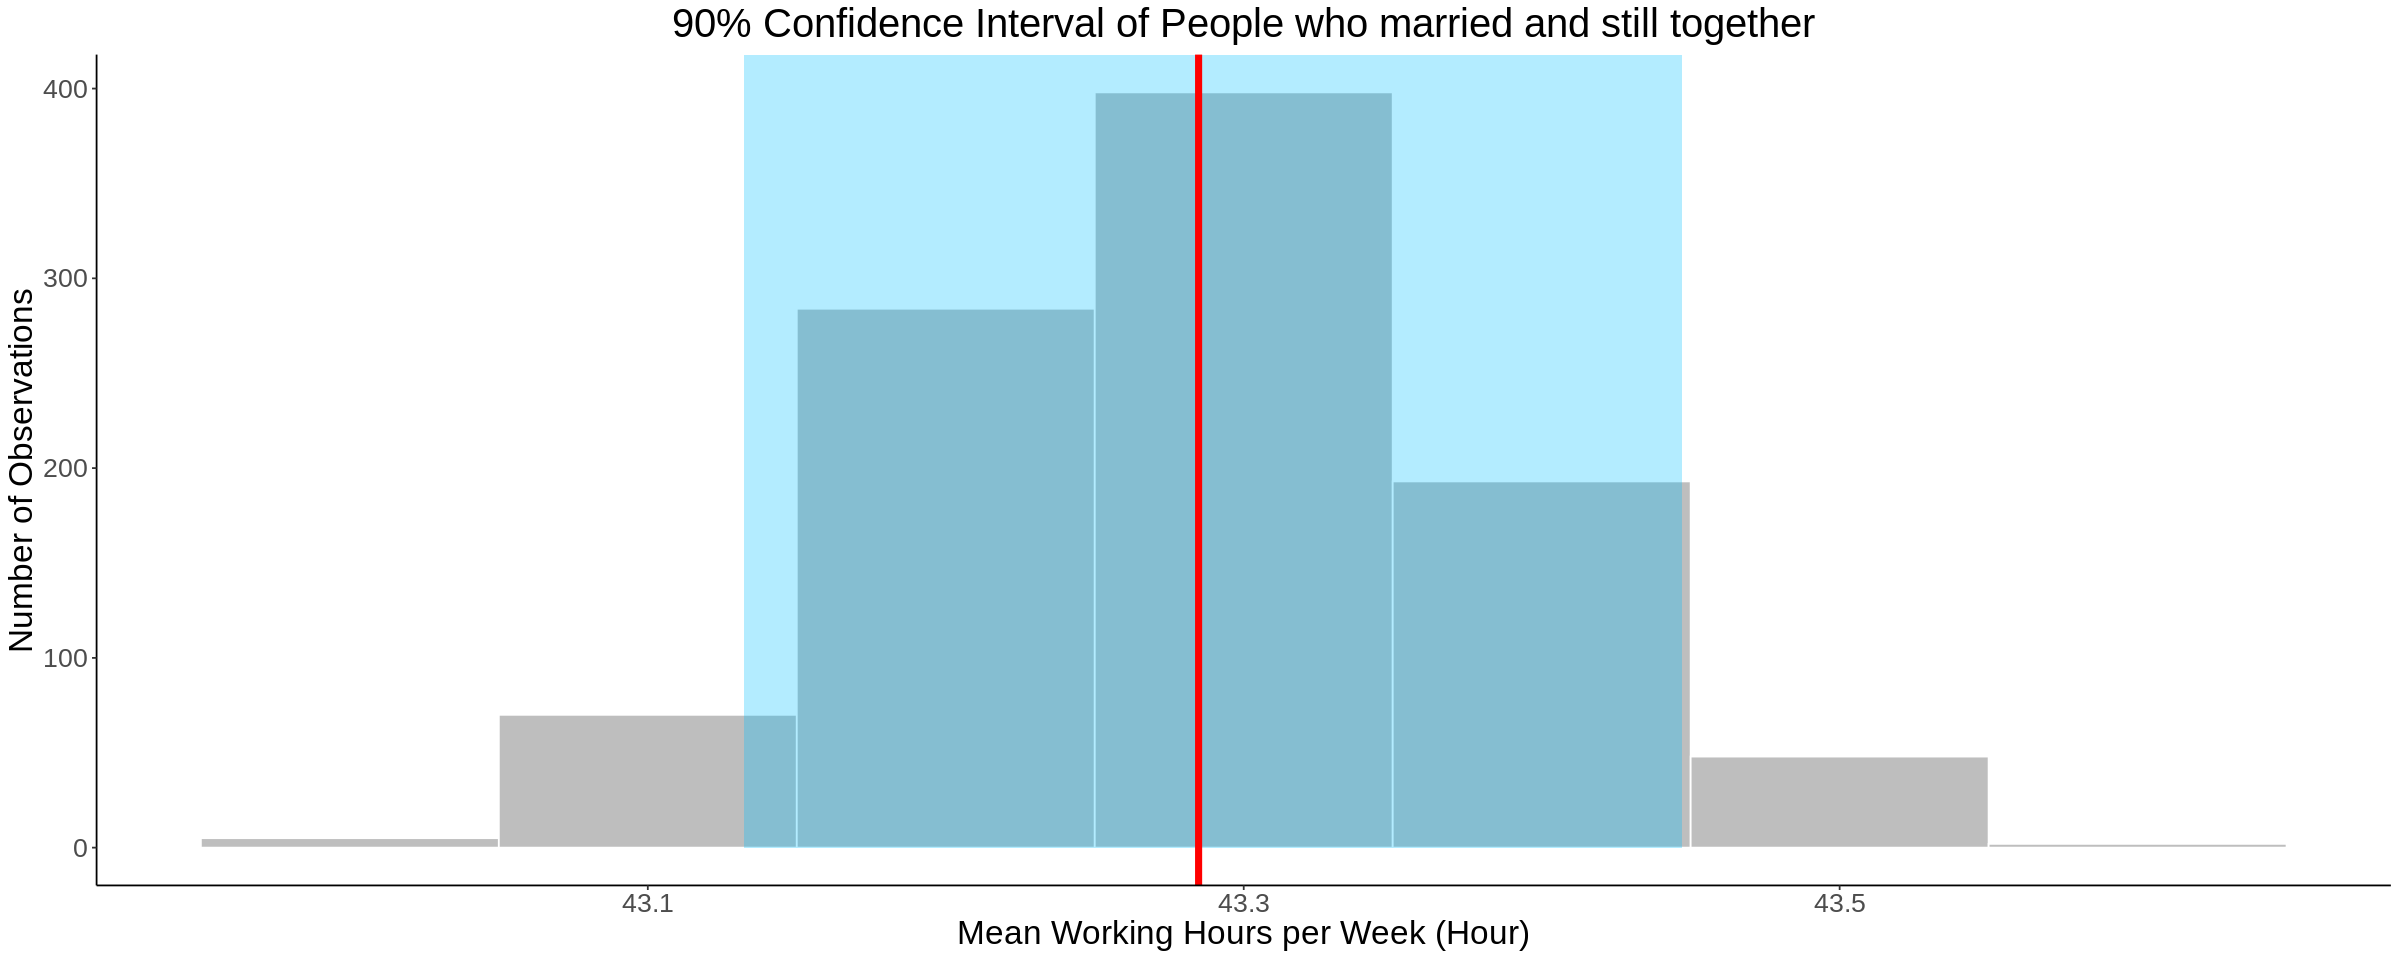

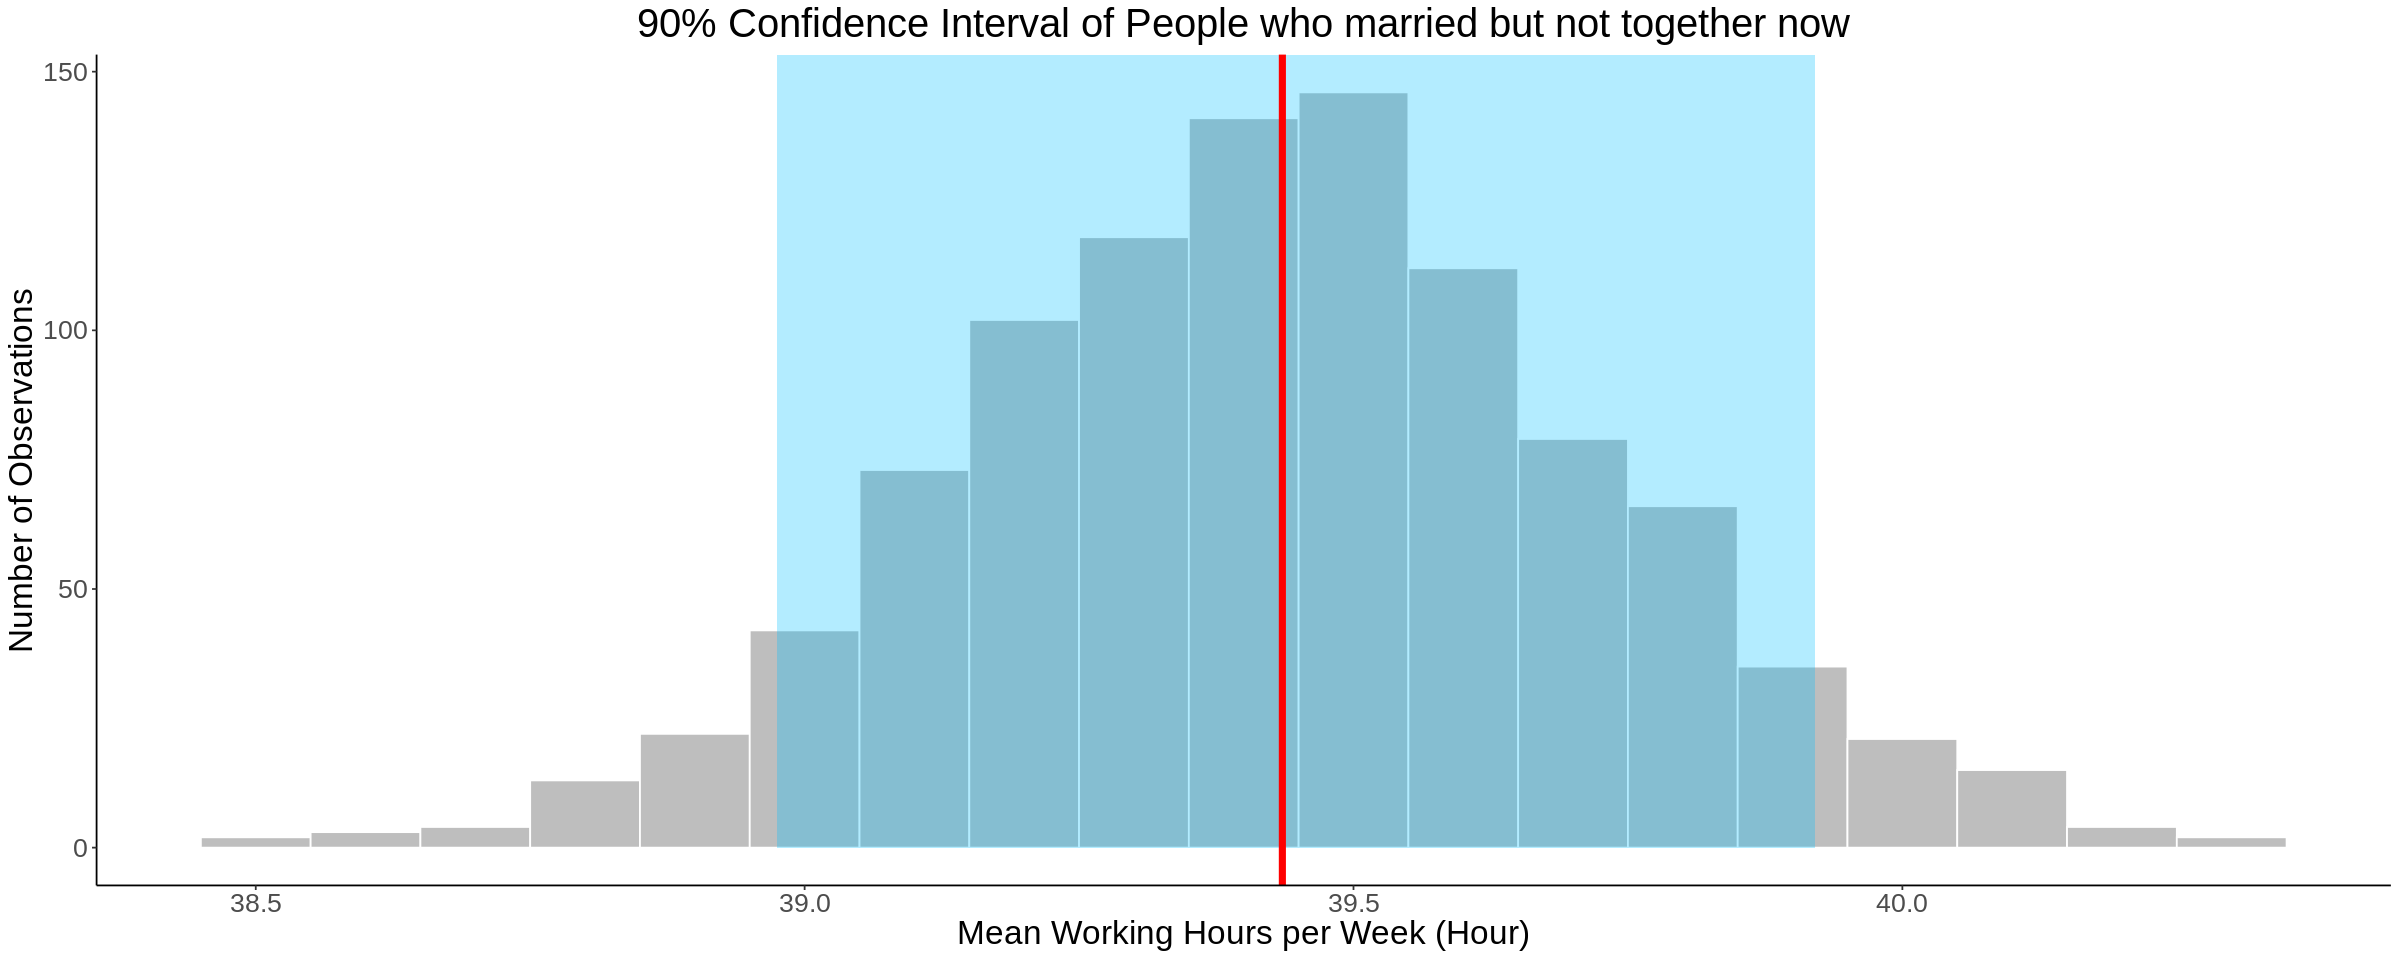

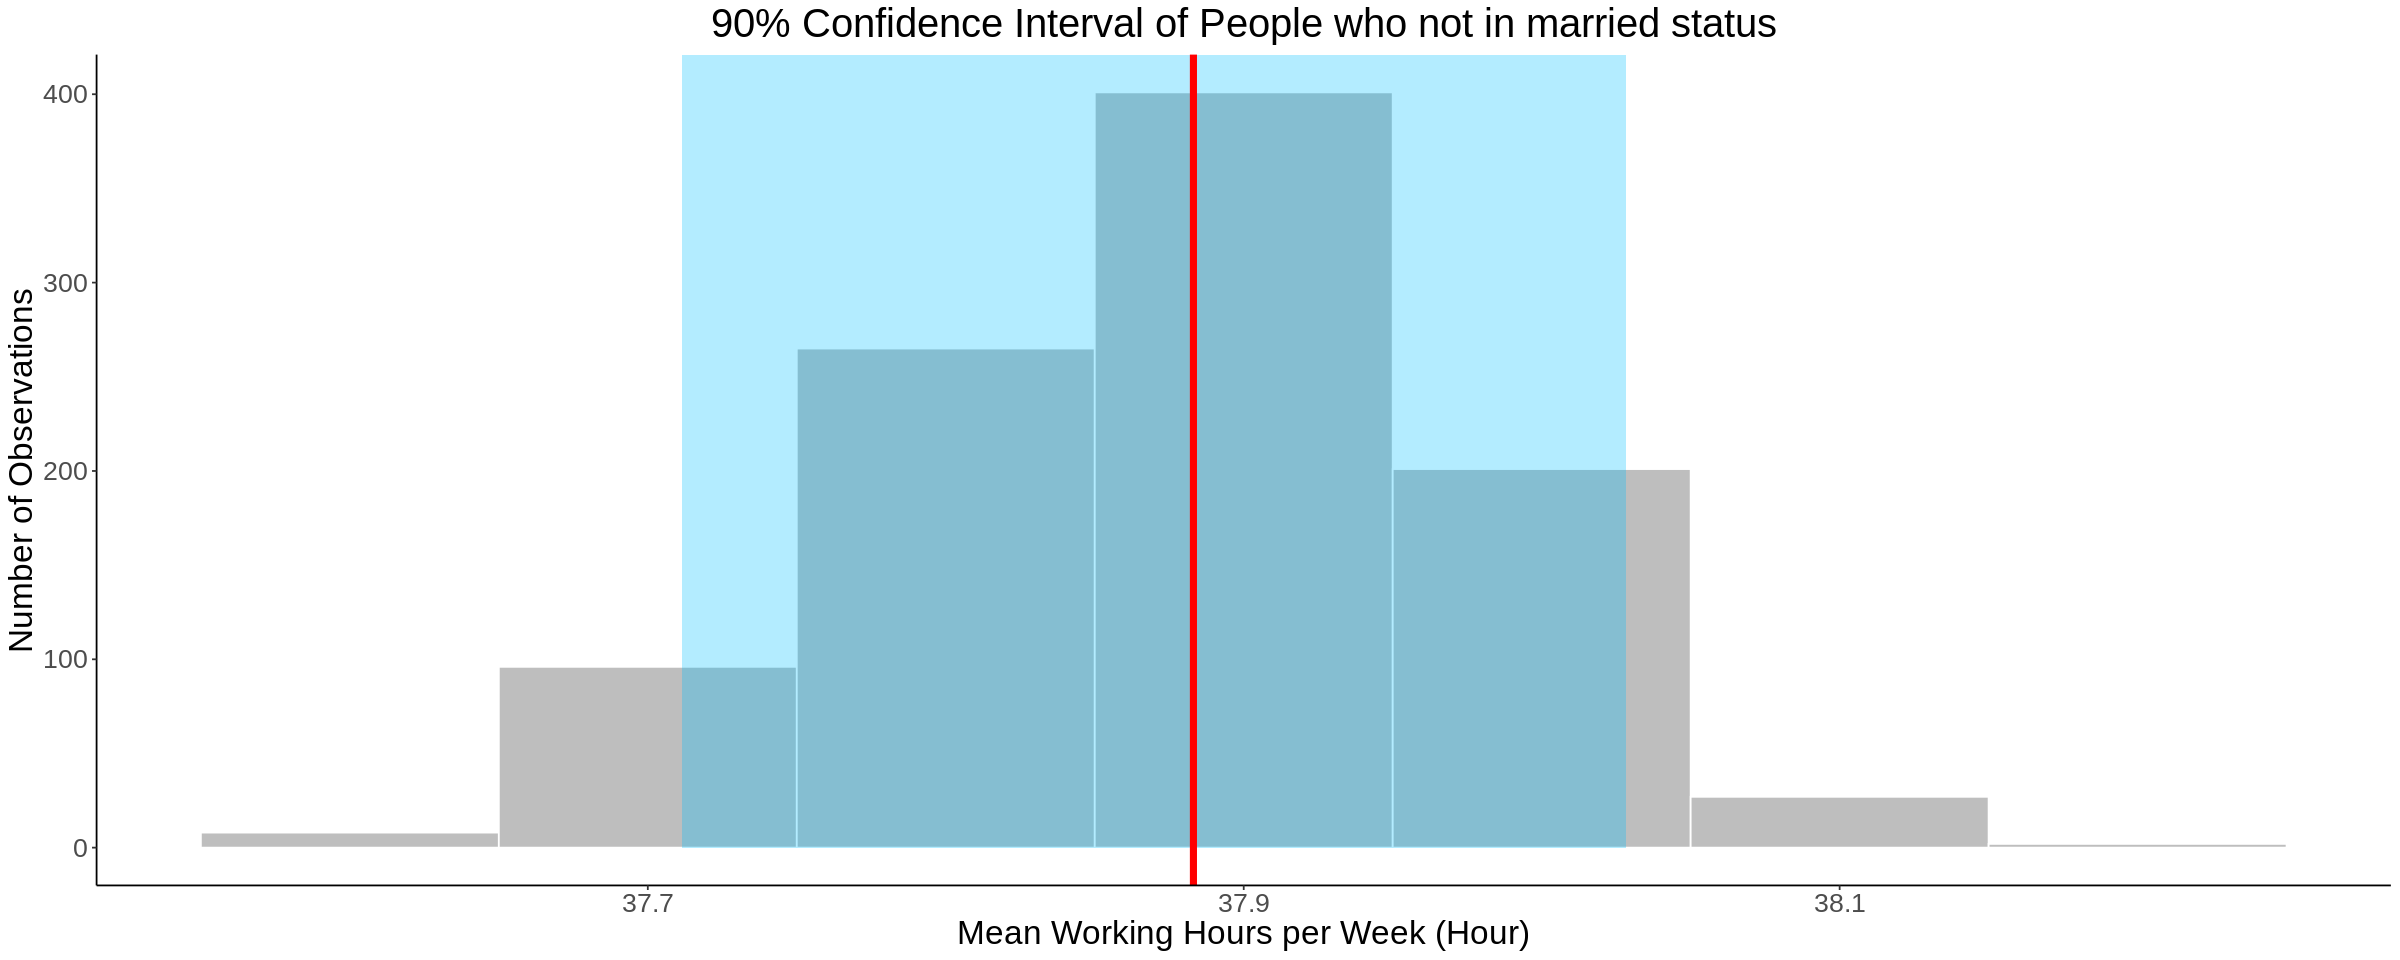

In [22]:
ci_3 <- married_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_3 <- married_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_3$ci_lower, xmax = ci_3$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = married_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who married and still together",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_3


ci_4 <- married_nt__mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_4 <- married_nt__mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_4$ci_lower, xmax = ci_4$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = married_nt_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who married but not together now",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_4

ci_5 <- not_married_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_5 <- not_married_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_5$ci_lower, xmax = ci_5$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = not_married_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who not in married status",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_5

**Asymptotic Method**

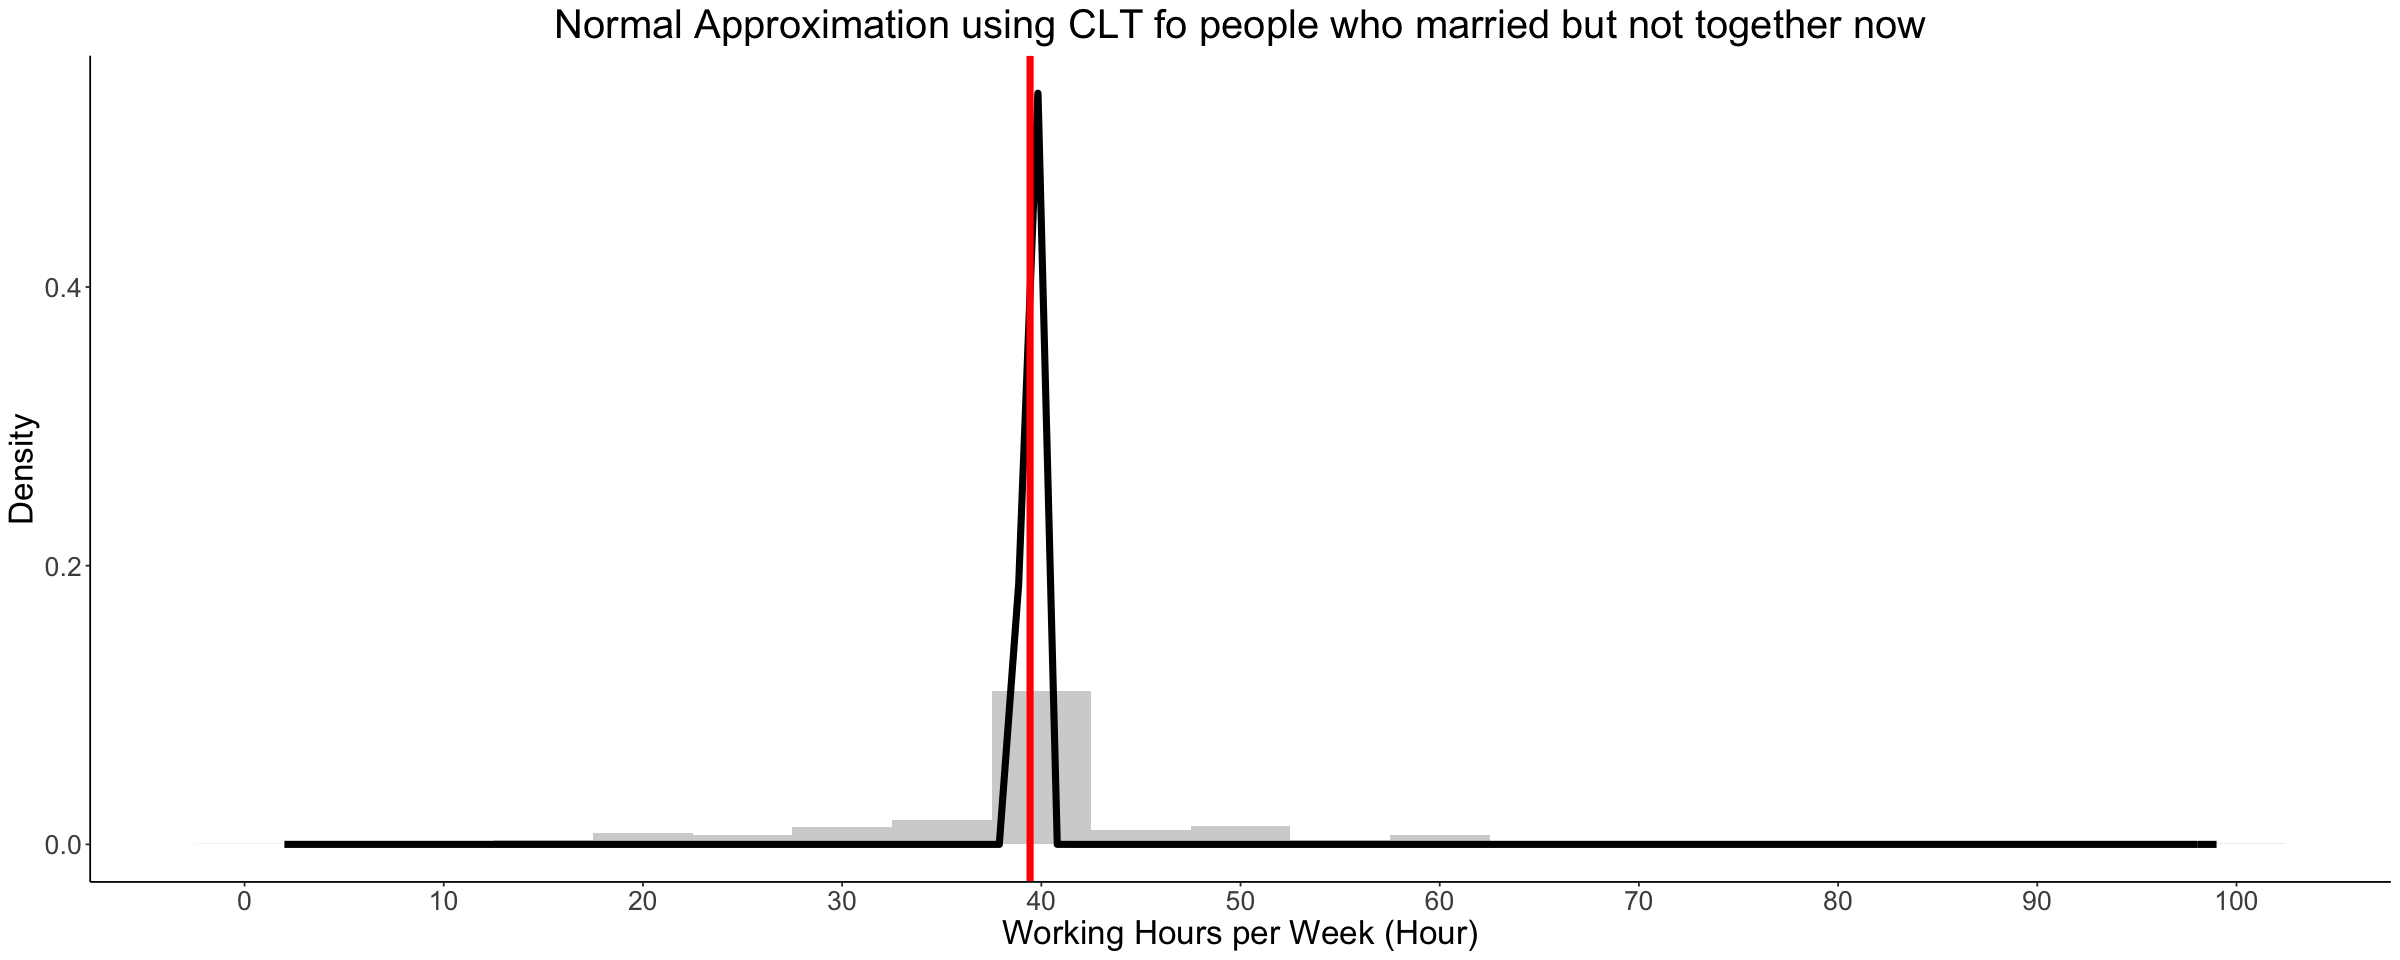

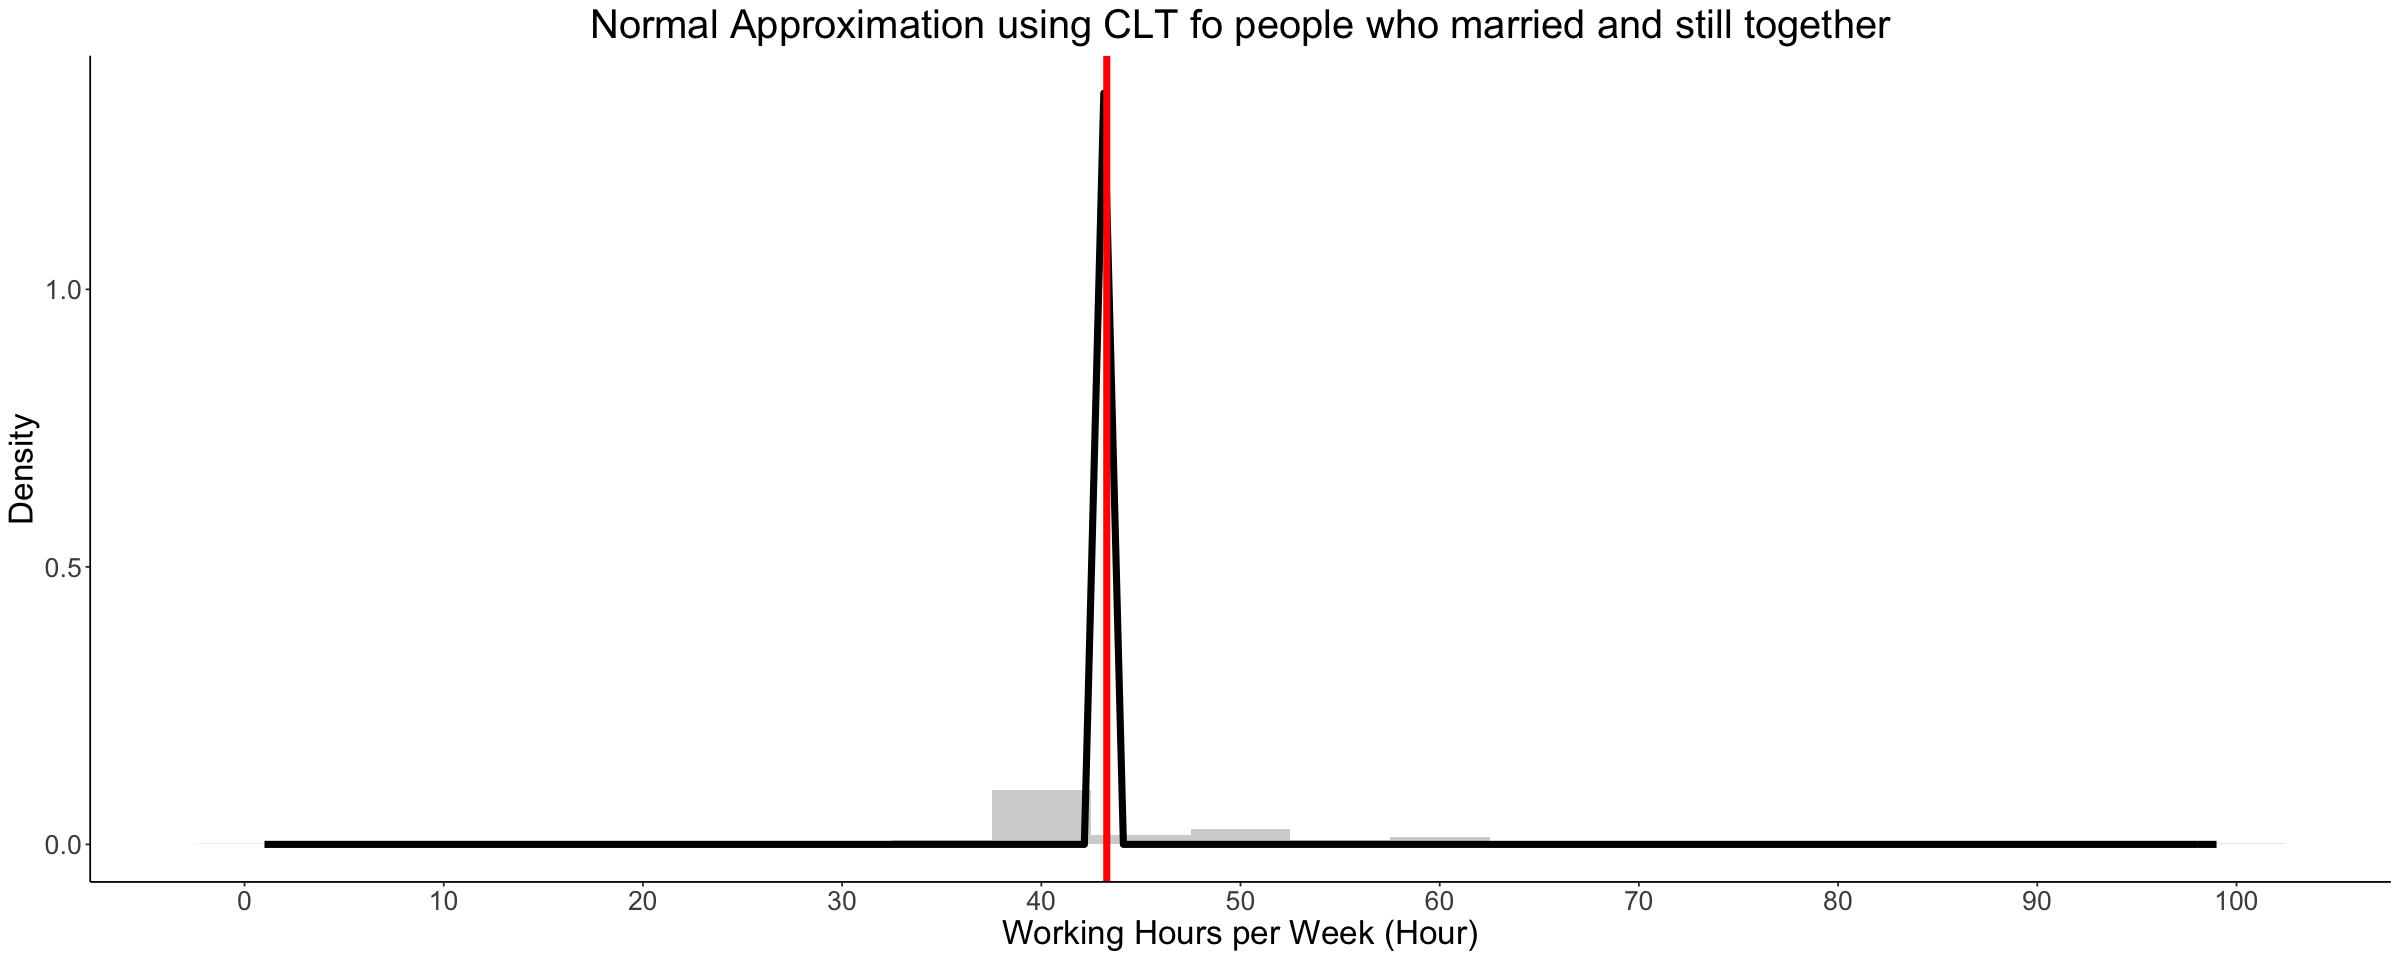

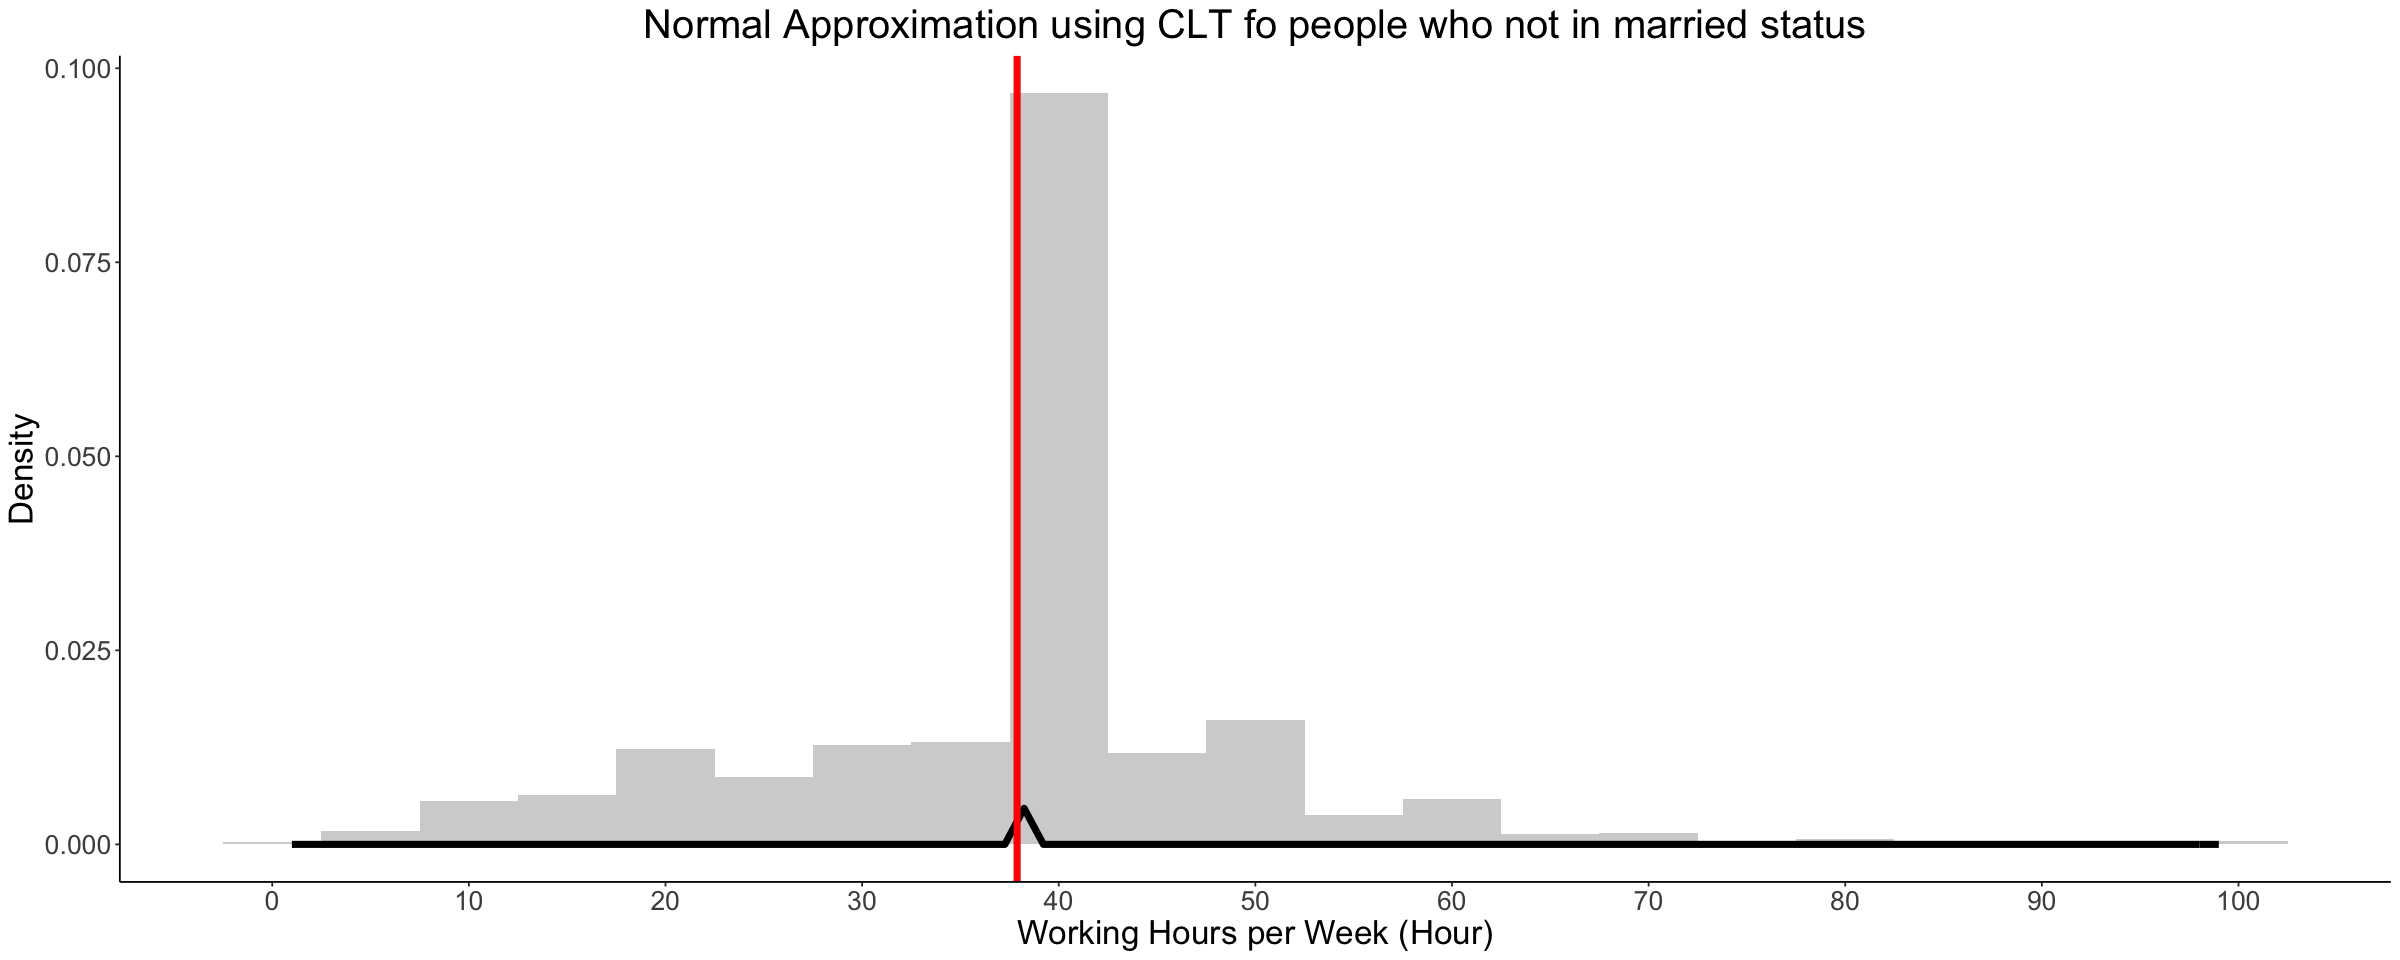

In [35]:
# CLT states, as n -> inf, X ~ Norm(mean, sd/sqrt(n)) 

married_not_t = data_ms %>%
    filter(marital_status == "Married-Not-Together")
married_t = data_ms %>% 
    filter(marital_status == "Married")
not_married = data_ms %>% 
    filter(marital_status == "Not-Married")

#married but not togethor right now plot
married_not_t_plot <- married_not_t %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT fo people who married but not together now",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(married_not_t$hours_per_week),
                                          sd = sd(married_not_t$hours_per_week) / sqrt(nrow(married_not_t))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(married_not_t$hours_per_week),
                  size = 2,
                  colour = "red")

#married and together plot        
married_t_plot <- married_t %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT fo people who married and still together",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(married_t$hours_per_week),
                                          sd = sd(married_t$hours_per_week) / sqrt(nrow(married_t))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(married_t$hours_per_week),
                  size = 2,
                  colour = "red")    

#never married befoer plot
not_married_plot <- not_married %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT fo people who not in married status",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(not_married$hours_per_week),
                                          sd = sd(not_married$hours_per_week) / sqrt(nrow(not_married))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(not_married$hours_per_week),
                  size = 2,
                  colour = "red")

married_not_t_plot
married_t_plot
not_married_plot
        

**Hypothesis Testing**

- $H_0$ : there is no difference between the means of people that are married, not married and married but seperated
- $H_A$ : there is a difference between the means of people that are married, not married and married but seperated

In [34]:
# REDO USING ORIGINAL DATASET

data_wc_f <- rbind(married_mean, married_nt__mean, not_married_mean)

oneway.test(mean_working_hour ~ marital_status, data = data_wc_f, var.equal = FALSE)


	One-way analysis of means (not assuming equal variances)

data:  mean_working_hour and marital_status
F = 798124, num df = 2.0, denom df = 1833.4, p-value < 2.2e-16


**P-Value**

### Mean Working Hours Based on Workclass

When looking at a person's workclass, we decided to compare those that work in the public sector, private sector, are self employed and those that volunteer. The dataset also has some other categories which are: and other "?" and "Never-worked", but for our analysis, we will not be looking at those because we are unsure about what "Never-worked" means in as the people categorized as this do have working hours. Also "?" is undefined and we would like to work with data points with known workclasses. To conduct this test, we are going to use the Welch ANOVA method because we are comparing more than two independent groups and our groups have different variances.

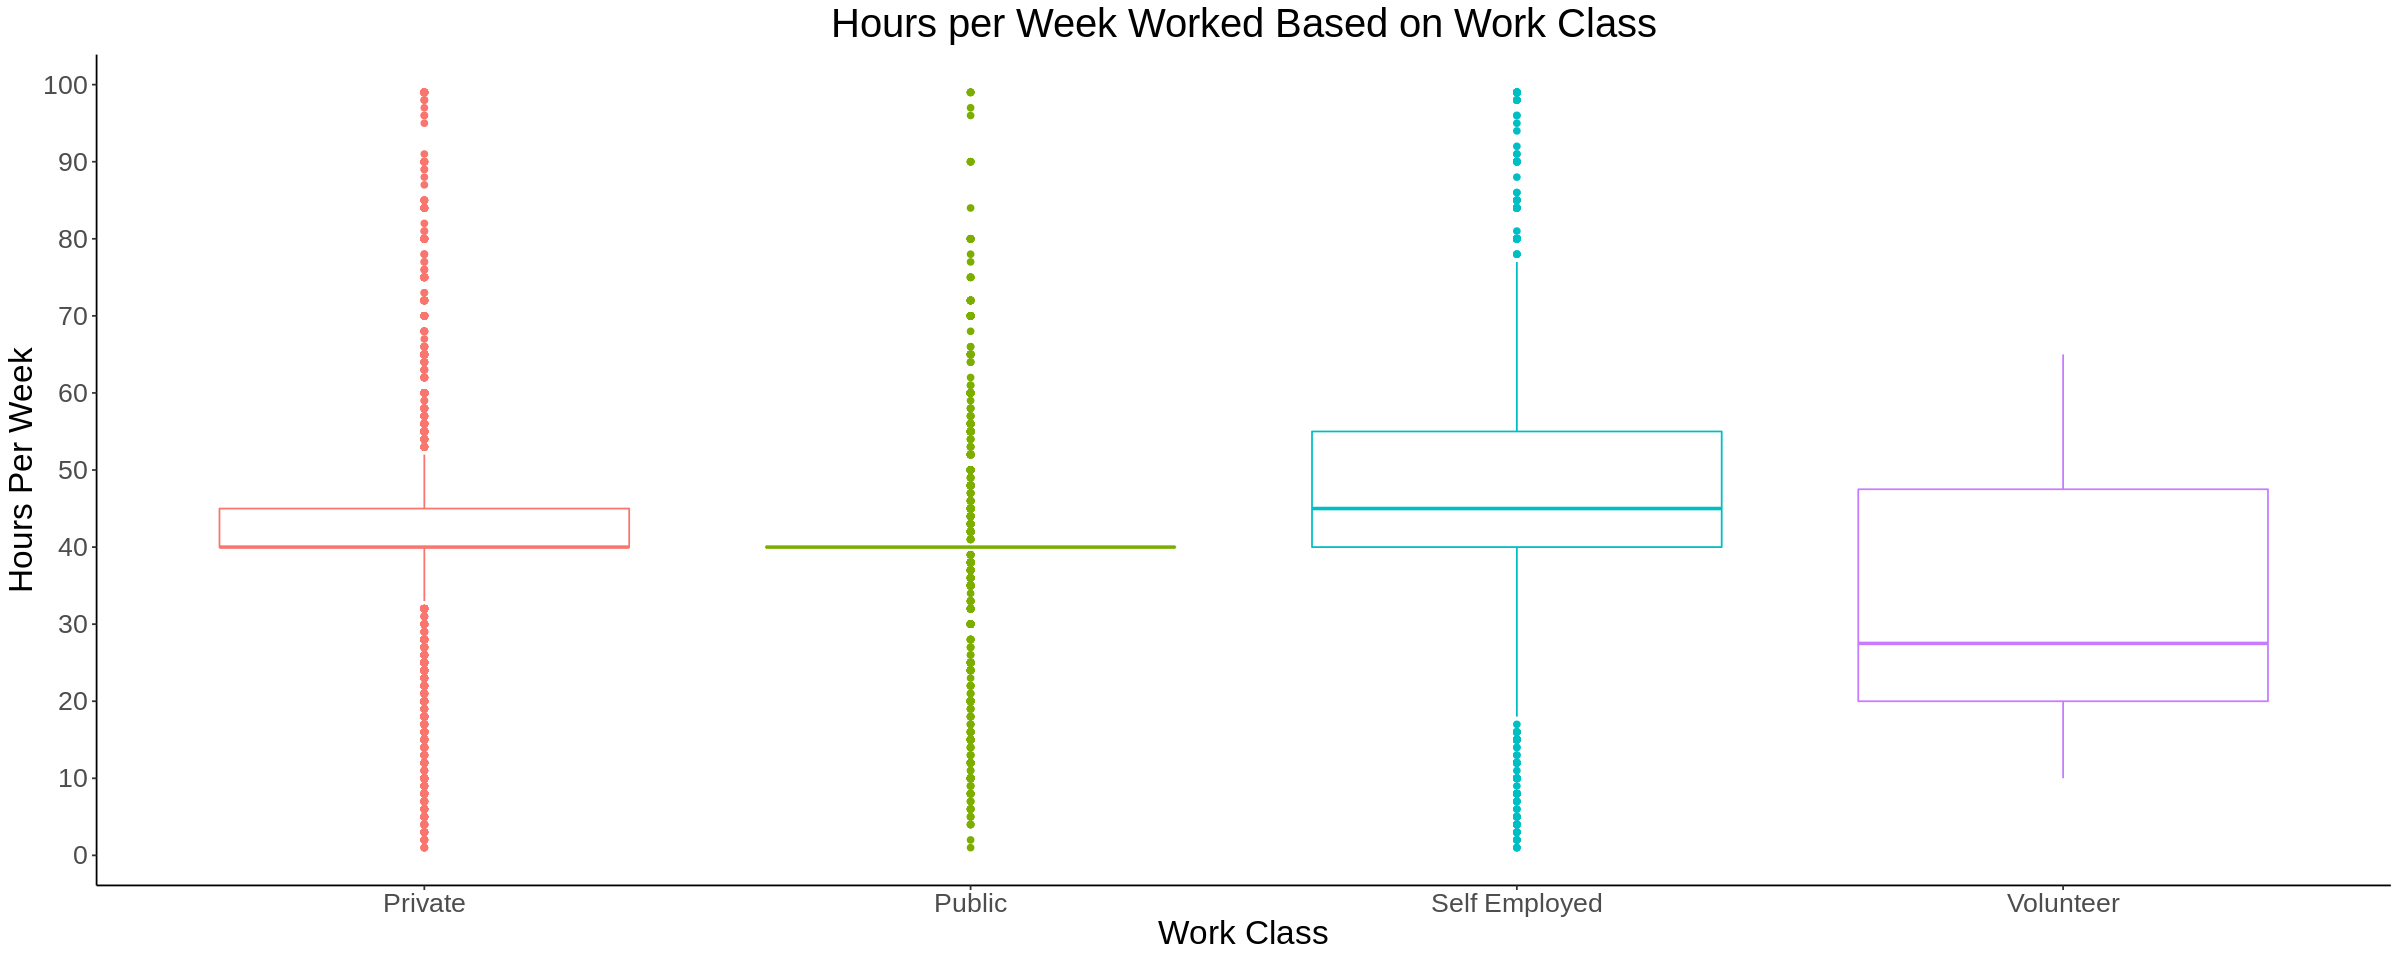

In [8]:
data_wc <- data %>%
    filter(work_class != "?") %>%
    filter(work_class != "Never-worked")

data_wc$work_class[data_wc$work_class == "Federal-gov" |
                   data_wc$work_class == "Local-gov" |
                   data_wc$work_class == "State-gov"] = "Public"

data_wc$work_class[data_wc$work_class == "Self-emp-inc" |
                   data_wc$work_class == "Self-emp-not-inc"] = "Self Employed"

data_wc$work_class[data_wc$work_class == "Without-pay"] = "Volunteer"

p <- data_wc %>%
    ggplot(aes(x = work_class, y = hours_per_week, color = work_class)) +
    geom_boxplot() +
    xlab("Work Class") +
    ylab("Hours Per Week") +
    ggtitle("Hours per Week Worked Based on Work Class") +
    plot_config +
    boxplot_scale

p

**Bootstrapping Method**

In [9]:
data_wc %>% group_by(work_class) %>% summarise(n = n())

work_class,n
<chr>,<int>
Private,22696
Public,4351
Self Employed,3657
Volunteer,14


In [ ]:
data_wc %>% group_by(work_class) %>% summarise(n = n())
compare_hour_low_hi_wc <- data_wc |> 
    group_by(work_class) |> 
    summarize(mean_hours_per_week=mean(hours_per_week)) |>
    pull()

compare_hour_low_hi_wc

private_mean_s <- compare_hour_low_hi_wc[1]
public_mean_s <- compare_hour_low_hi_wc[2]
self_mean_s <- compare_hour_low_hi_wc [3]
volunteer_mean_s <- compare_hour_low_hi_wc [4]

Below we are taking bootstrap samples, grouping them, computing the mean working hours for each group and selecting the `work_class` and `mean_working_hour` columns

In [10]:
private_bootstrap <- data_wc %>%
    filter(work_class == "Private") %>%
    rep_sample_n(reps= 1000, size = 22696, replace = TRUE)

public_bootstrap <- data_wc %>%
    filter(work_class == "Public") %>%
    rep_sample_n(reps= 1000, size = 4351, replace = TRUE)

self_bootstrap <- data_wc %>%
    filter(work_class == "Self Employed") %>%
    rep_sample_n(reps= 1000, size = 3657, replace = TRUE)

volunteer_bootstrap <- data_wc %>%
    filter(work_class == "Volunteer") %>%
    rep_sample_n(reps= 1000, size = 14, replace = TRUE)

In [11]:
private_mean <- private_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(work_class = "Private") %>%
    select(work_class, mean_working_hour)

In [13]:
public_mean <- public_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(work_class = "Public") %>%
    select(work_class, mean_working_hour)

In [28]:
self_mean <- self_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(work_class = "Self-Employed") %>%
    select(work_class, mean_working_hour)

volunteer_mean <- volunteer_bootstrap %>%
    group_by(replicate) %>%
    summarize(mean_working_hour = mean(hours_per_week)) %>%
    mutate(work_class = "Volunteer") %>%
    select(work_class, mean_working_hour)

ci_lower,ci_upper
<dbl>,<dbl>
40.1469,40.39071


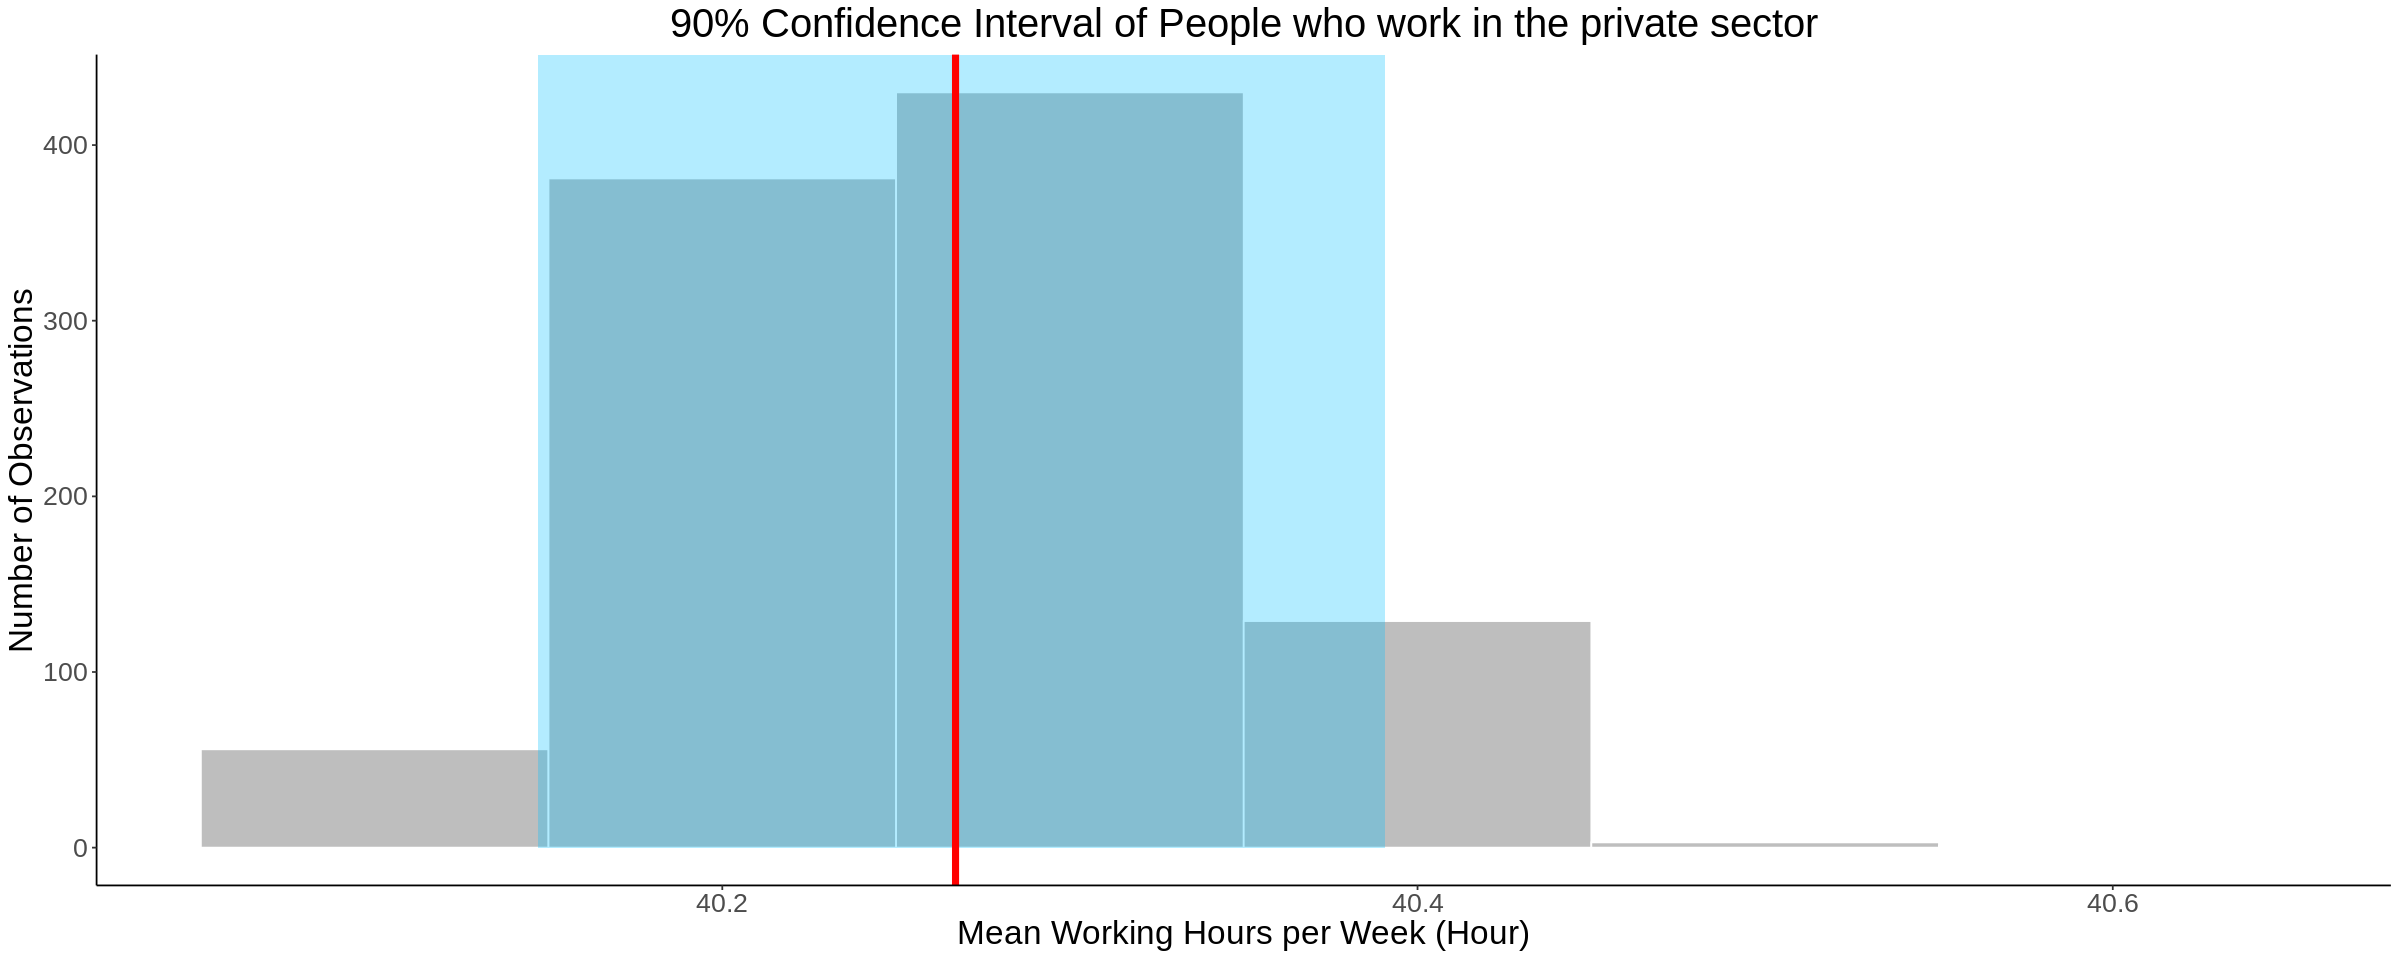

In [32]:
ci_6 <- private_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_6 <- private_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_6$ci_lower, xmax = ci_6$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = private_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who work in the private sector",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_6

ci_6

In [ ]:
ci_7 <- public_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_7 <- public_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_7$ci_lower, xmax = ci_7$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = public_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who work in the public sector",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_7

ci_7

ci_lower,ci_upper
<dbl>,<dbl>
45.31164,46.20893


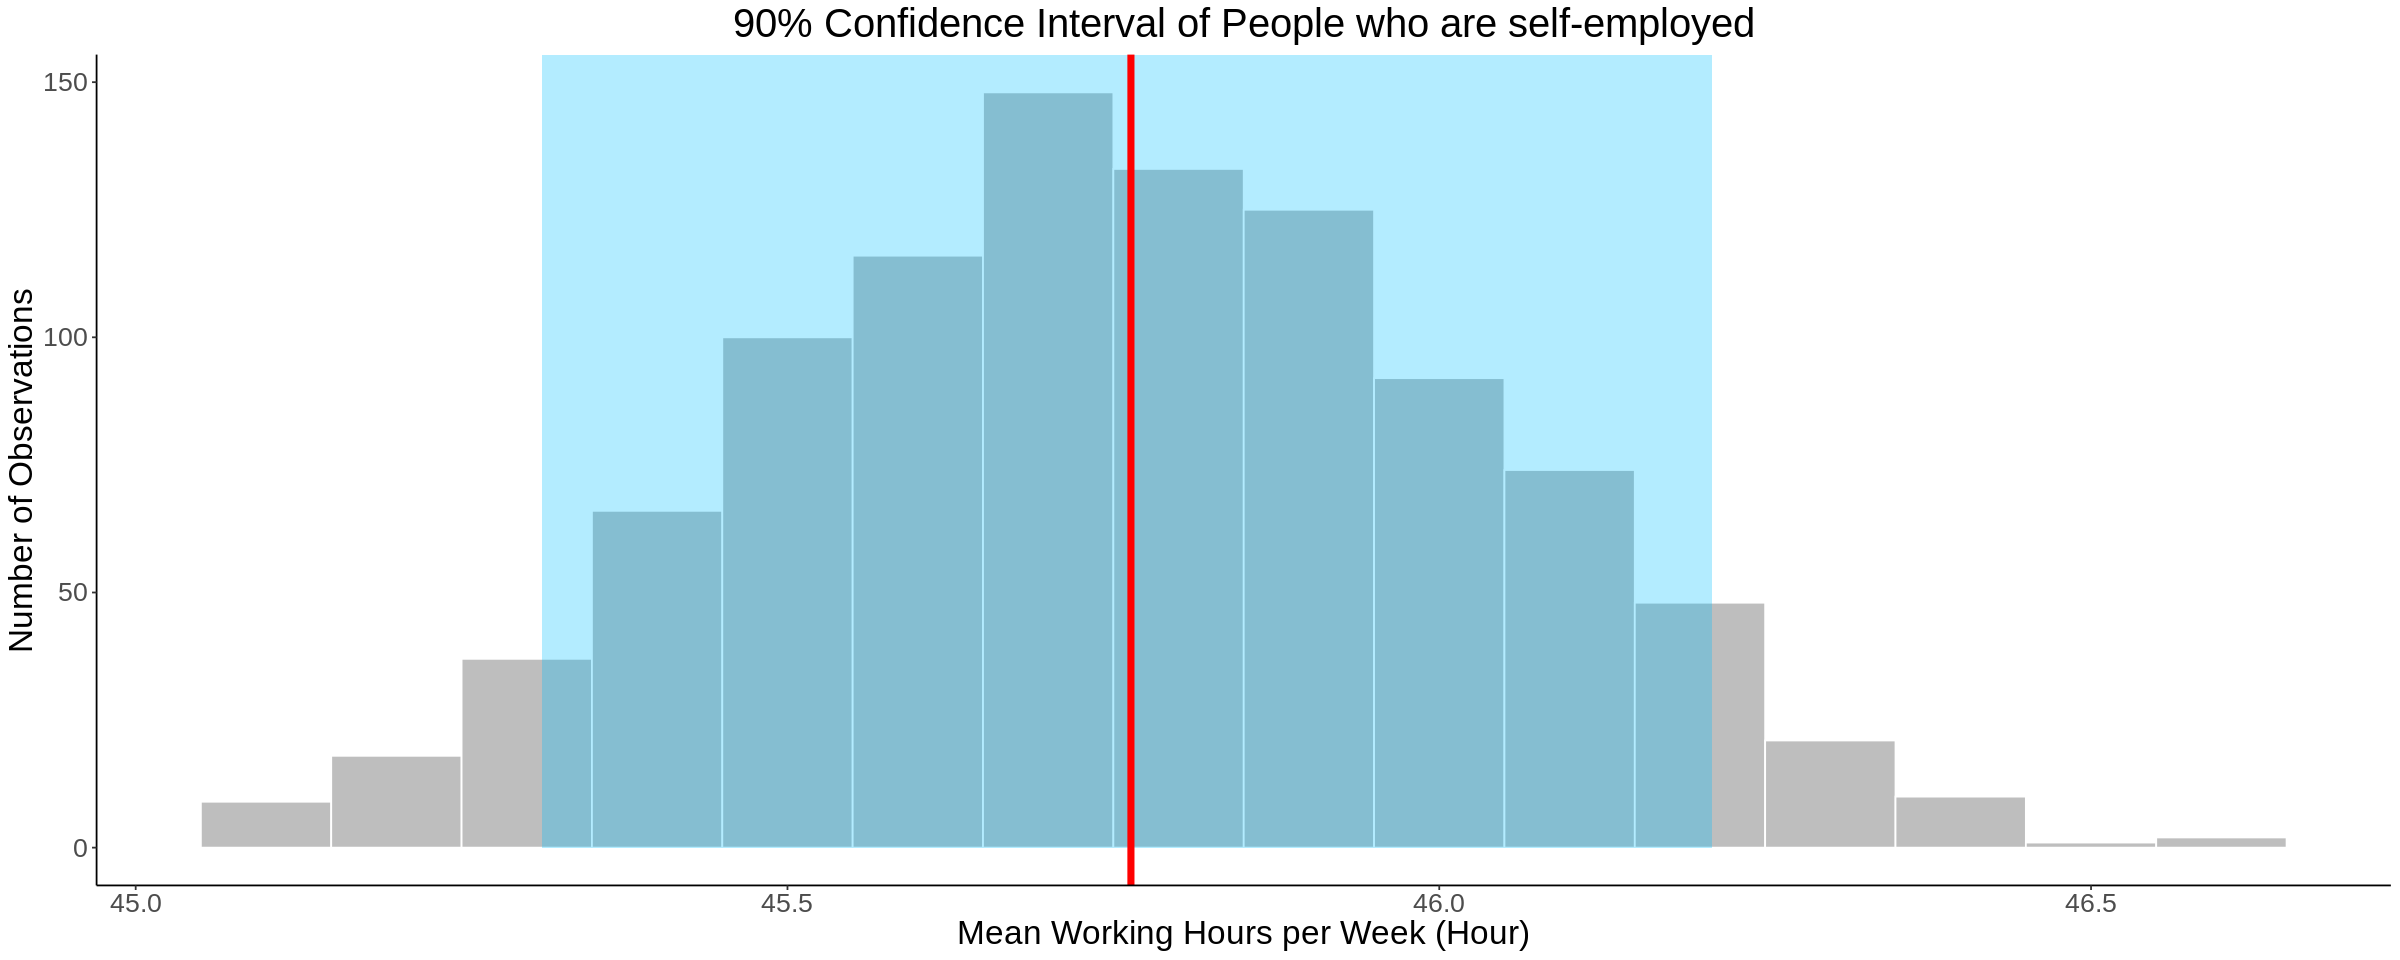

ci_lower,ci_upper
<dbl>,<dbl>
25.63571,40.5


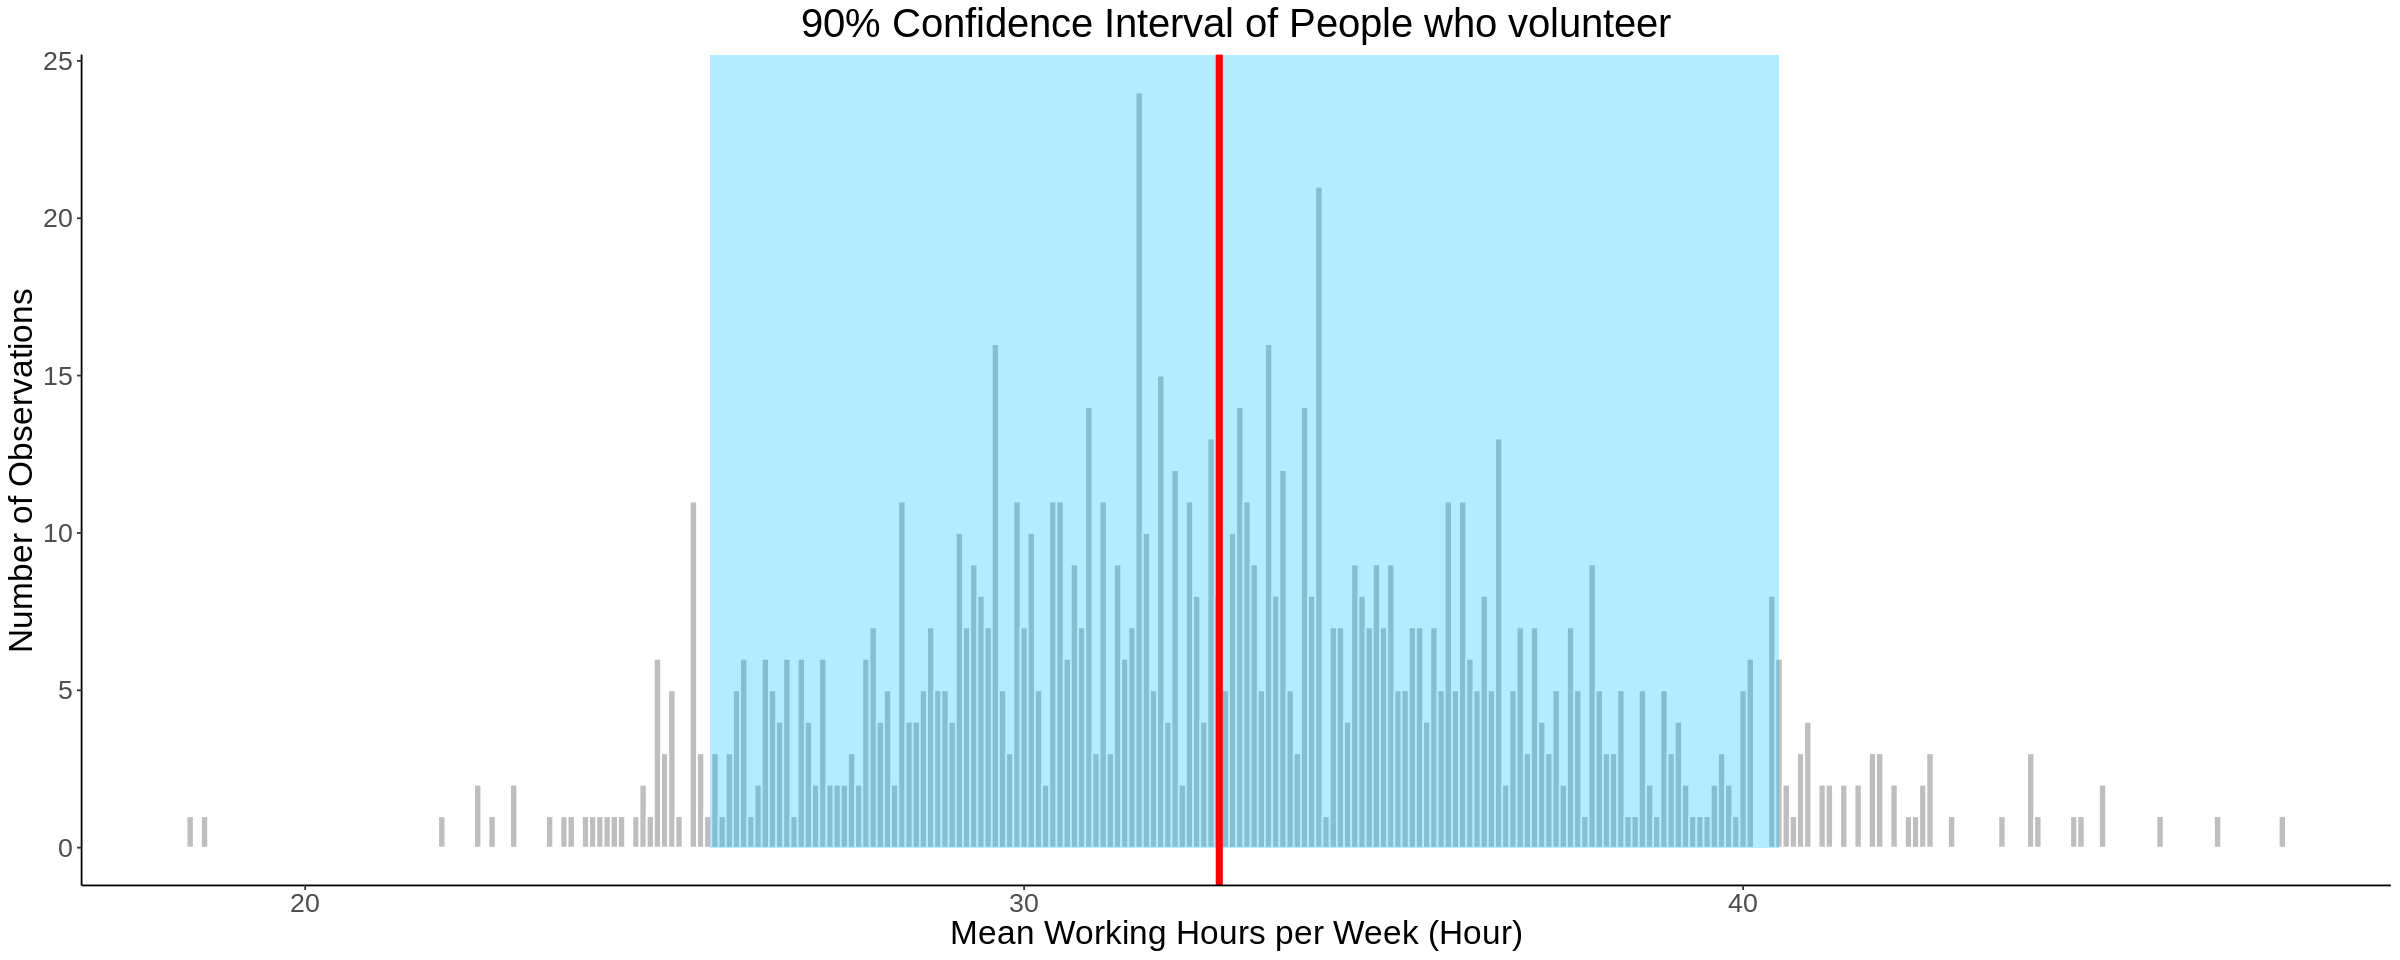

In [31]:
ci_8 <- self_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_8 <- self_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_8$ci_lower, xmax = ci_8$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = self_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who are self-employed",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_8

ci_8

ci_9 <- volunteer_mean |>
    summarize(ci_lower = quantile(mean_working_hour,0.05),
              ci_upper = quantile(mean_working_hour,0.95))
ci_plot_9 <- volunteer_mean |> 
    ggplot(aes(x = mean_working_hour)) +
    geom_histogram(colour = "white", fill = "grey", binwidth = 0.1) +
    annotate("rect", xmin = ci_9$ci_lower, xmax = ci_9$ci_upper, ymin = 0, ymax = Inf,
             fill = "deepskyblue",
             alpha = 0.3) +
    geom_vline(xintercept = volunteer_mean_s,
               size = 2,
               colour = "red") +
    labs(title = "90% Confidence Interval of People who volunteer",
         x = "Mean Working Hours per Week (Hour)",
         y = "Number of Observations")  +
    plot_config
ci_plot_9

ci_9

In [33]:
# CLT states, as n -> inf, X ~ Norm(mean, sd/sqrt(n)) 

private_t = data_wc %>%
    filter(work_class == "Private")
public_t = data_wc %>%
    filter(work_class == "Public")
self_t = data_wc %>%
    filter(work_class == "Self Employed")
volunteer_t = data_wc %>%
    filter(work_class == "Volunteer")

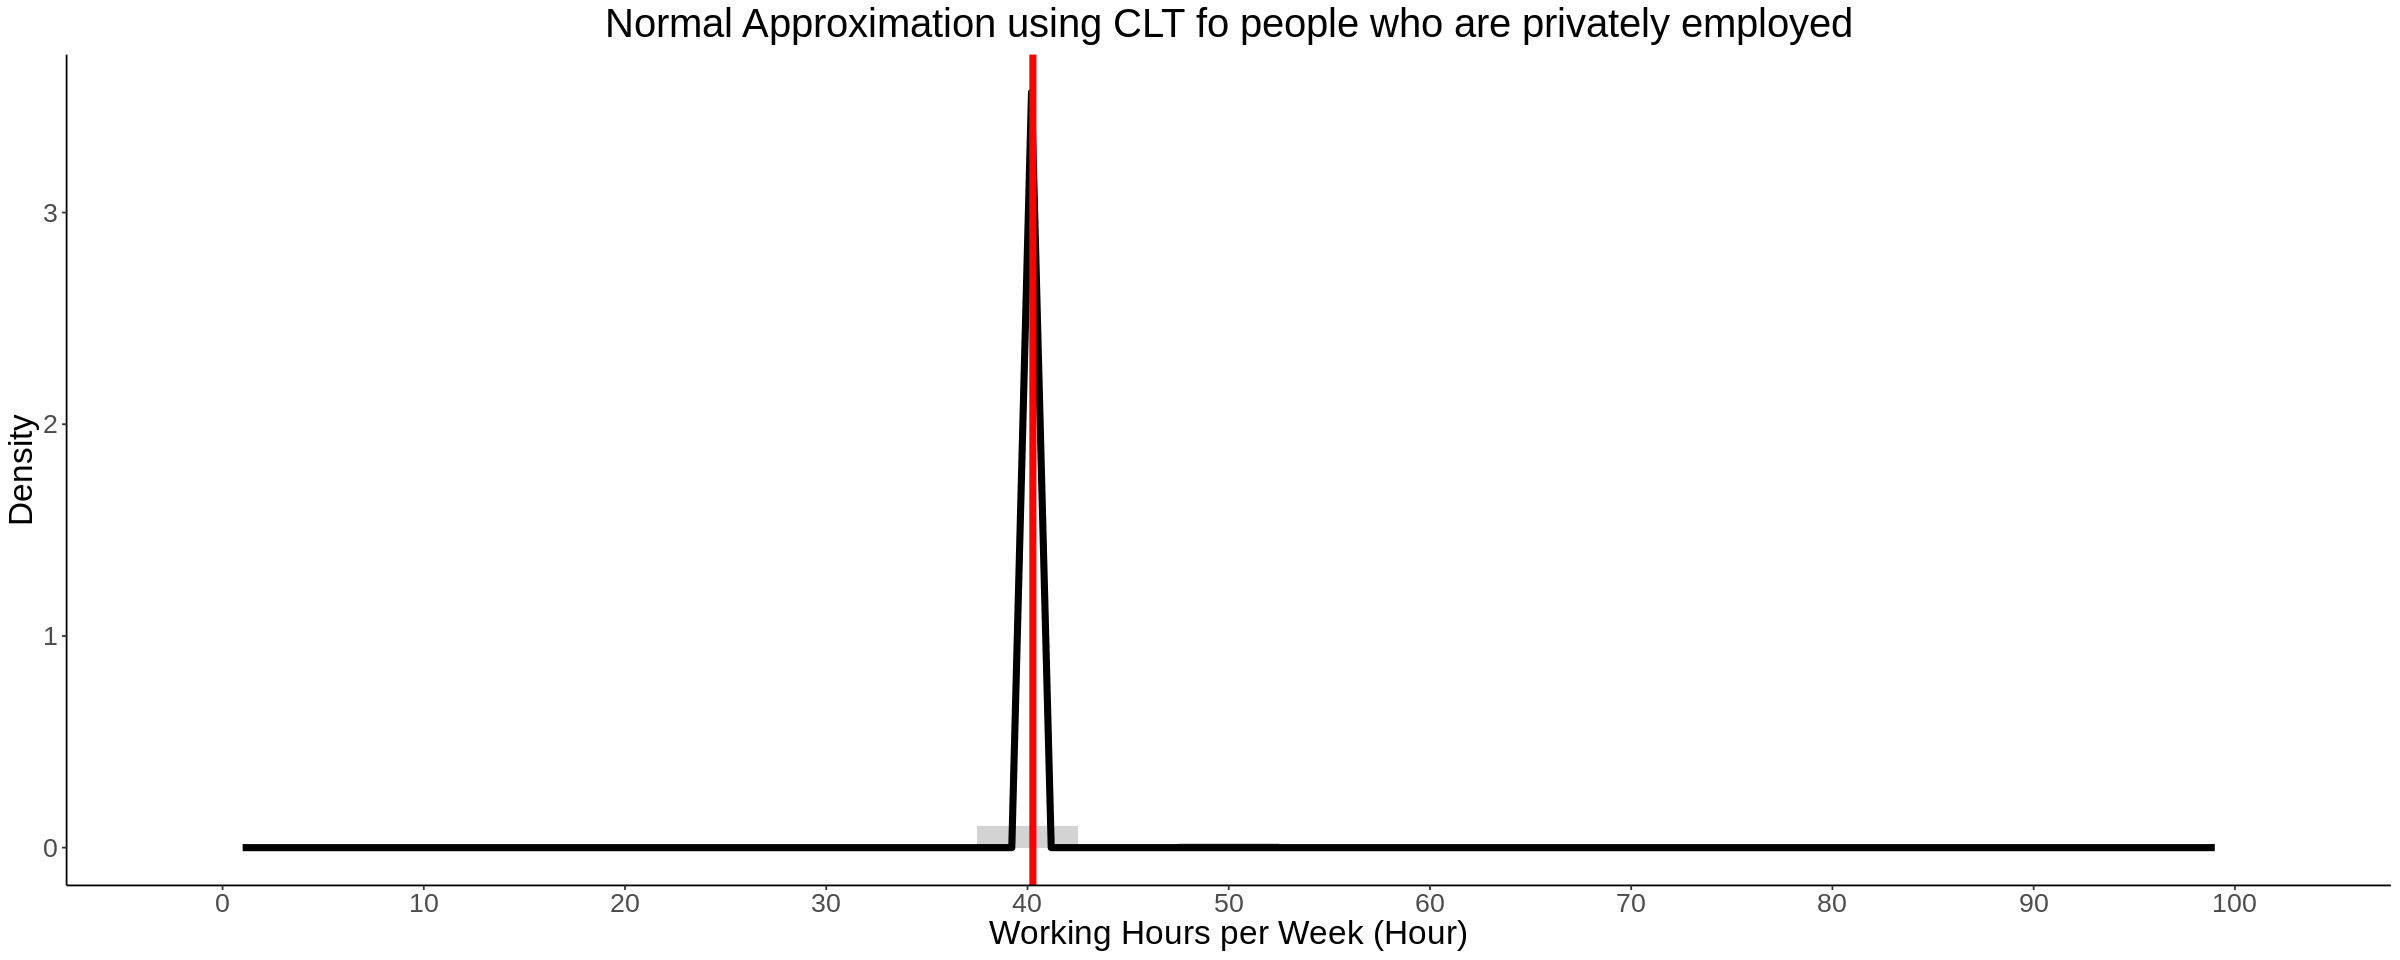

In [35]:
#privately employed plot
private_t_plot <- private_t %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT fo people who are privately employed",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(private_t$hours_per_week),
                                          sd = sd(private_t$hours_per_week) / sqrt(nrow(private_t))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(private_t$hours_per_week),
                  size = 2,
                  colour = "red")

private_t_plot

In [ ]:
# publicly employed plot        
public_t_plot <- public_t %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT for people who are publicly employed",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(public_t$hours_per_week),
                                          sd = sd(public_t$hours_per_week) / sqrt(nrow(public_t))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(public_t$hours_per_week),
                  size = 2,
                  colour = "red")    

#self-employed plot
self_t_plot <- self_t %>%
    ggplot(aes(x = hours_per_week)) +
    geom_histogram(aes(y = ..density..), fill = "lightgray", binwidth=5) +
    labs(title = "Normal Approximation using CLT for people who are self-employed",
        x = "Working Hours per Week (Hour)",
        y = "Density") +
    stat_function(fun = dnorm, args = list(mean = mean(self_t$hours_per_week),
                                          sd = sd(self_t$hours_per_week) / sqrt(nrow(self_t))),
                 color = "black", size = 2) +
        plot_config +
        scale_x_continuous(breaks = seq(0,100,10)) +
        geom_vline(xintercept = mean(self_t$hours_per_week),
                  size = 2,
                  colour = "red")


        

**Hypothesis Testing**

- $H_0$ : there is no difference between the means of people who work in private sector, public sector, are self-employed or volunteer
- $H_A$ : there is a difference between the means of people who work in private sector, public sector, are self-employed or volunteer

Below we are running our Welch ANOVA test by first combining each of the four groups into one dataframe, then running a `oneway` test with `var.equal = FALSE` because the variance of each group is different.

In [36]:
# REDUE USING ORIGINAL DATASET

data_wc_f <- rbind(private_mean, public_mean, self_mean, volunteer_mean)

oneway.test(mean_working_hour ~ work_class, data = data_wc_f, var.equal = FALSE)

ERROR: Error in rbind(private_mean, public_mean, self_mean, volunteer_mean): object 'private_mean' not found


**P-Value**

## Discussion

For education variable, with p-value > 0.05, null hypothesis is not rejected at significant level of 95%. There is no significant difference in mean of average working hours per week between the groups of More-than-HS people and Less-than-HS. 

For marital status variable, with p-value < 0.05, null hypothesis is rejected at significant level of 95%. There is a significant difference in the average working hours per week between the groups of people that are married, not married and married but seperated.

For workclass variable, with p-value > 0.05, null hypothesis is not rejected at significant level of 95%. There is no significant difference in the average working hours per week between the groups of people who work in private sector, public sector, are self-employed or volunteer.

The finding of education variable shows that education level does not impact the number of hours worked. Future works can test if there is a significant difference in income of different education levels, it may encourage more students to continue their education to higher level since the income per hour worked will be impacted. Finding of workclass status shows that workclass also does not impact the number of hours worked, hence future workforce can use factor in this finding while choosing their future jobs. Out of 3 variables tested, only marital status impacts number of hours worked per week. It indicates that people with different marital status may have different levels of priority for work-life balance.

## References

Kohavi, R., &amp; Becker, B. (1996, May 1). Adult Data Set. Retrieved 2021, from https://archive.ics.uci.edu/ml/datasets/adult. This database was found with assistance of:
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Kim, H., Suh, B. S., Lee, W. C., Jeong, H. S., Son, K. H., Nam, M. W., & Kim, H. C. (2019). The association between long working hours and marital status change: middle-aged and educated Korean in 2014-2015. Annals of occupational and environmental medicine, 31, e3. https://doi.org/10.35371/aoem.2019.31.e3

Kim, Hyunil MD; Lee, Woncheol MD; Lee, Yesung MD Association of Long Working Hours With Marital Status Changes in South Korea, Journal of Occupational and Environmental Medicine: October 2021 - Volume 63 - Issue 10 - p e689-e693
doi: 10.1097/JOM.0000000000002338